![](https://miro.medium.com/max/4800/1*QBg4uRx67x2mEXt0ROjGYw.png)

<div align='left'><font size='5' color='#FF5A5F'> Airbnb Seattle Open Data Analysis</font></div>

- In this notebook I am interested in finding answer to 3 questions:
    1. What type of housing are most commonly listed on Airbnb in Seattle?
    2. When are airbnbs booked the most in Seattle? In other words, what time of the year or occasions are airbnb most popular?
    3. Is there any correlation between listing price and review scores? In other words, does higher price yield a higher average review score?

<div align='left'><font size='5' color='#FF5A5F'> Table of Contents </font></div>

- [Loading Libraries](#1)
- [Loading Data ](#2)
- [Understanding Data](#3)
- [Data Cleaning](#4)
- [Explorartory Data Analysis](#5)
- [Housing Types on Airbnb Seattle](#6)
- [Airbnb Popularity in Seattle](#7)
- [Listing Prices & Review Scores between regularhost and superhost](#8)

### [Loading libraries](#1)<a id="1"></a> <br>

In [1]:
# Loading all libraries
from datetime import datetime
start_time = datetime.now()

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE

#pip install holidays
from datetime import date
import holidays

import time
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix
from scipy import stats

print('LOAD DURATION:',datetime.now() - start_time)

LOAD DURATION: 0:00:01.969542


### [Loading Data](#2)<a id="2"></a> <br>

In [151]:
calendar = pd.read_csv("calendar.csv")
listing = pd.read_csv("listings.csv")
review = pd.read_csv("reviews.csv")

In [141]:
calendar.head(3)

,listing_id,date,available,price
0,241032,2016-01-04,t,85.0
1,241032,2016-01-05,t,85.0
2,241032,2016-01-06,f,NaN


In [4]:
listing.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15


In [5]:
review.head(3)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."


### [Understanding Data](#3)<a id="3"></a> <br>

In [6]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


In [7]:
listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [8]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     84849 non-null  int64 
 1   id             84849 non-null  int64 
 2   date           84849 non-null  object
 3   reviewer_id    84849 non-null  int64 
 4   reviewer_name  84849 non-null  object
 5   comments       84831 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


In [9]:
# check for missing values
print(f'There are {calendar.isnull().any().sum()} columns in calendar dataset with missing values.')
print(f'There are {listing.isnull().any().sum()} columns in listing dataset with missing values.')
print(f'There are {review.isnull().any().sum()} columns in review dataset with missing values.')

There are 1 columns in calendar dataset with missing values.
There are 45 columns in listing dataset with missing values.
There are 1 columns in review dataset with missing values.


In [10]:
# numerical fields in the listing dataset
listing.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,3818.0,5.550111e+06,2.962660e+06,3.335000e+03,3.258256e+06,6.118244e+06,8.035127e+06,1.034016e+07
scrape_id,3818.0,2.016010e+13,0.000000e+00,2.016010e+13,2.016010e+13,2.016010e+13,2.016010e+13,2.016010e+13
host_id,3818.0,1.578556e+07,1.458382e+07,4.193000e+03,3.275204e+06,1.055814e+07,2.590309e+07,5.320861e+07
host_listings_count,3816.0,7.157757e+00,2.862815e+01,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,5.020000e+02
host_total_listings_count,3816.0,7.157757e+00,2.862815e+01,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,5.020000e+02
latitude,3818.0,4.762896e+01,4.305195e-02,4.750509e+01,4.760942e+01,4.762360e+01,4.766269e+01,4.773336e+01
longitude,3818.0,-1.223331e+02,3.174451e-02,-1.224172e+02,-1.223543e+02,-1.223289e+02,-1.223108e+02,-1.222406e+02
accommodates,3818.0,3.349398e+00,1.977599e+00,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.600000e+01
bathrooms,3802.0,1.259469e+00,5.903691e-01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,8.000000e+00
bedrooms,3812.0,1.307712e+00,8.833949e-01,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,7.000000e+00


### [Data Cleaning](#4)<a id="4"></a> <br>

Pick columns that are relevant to anwsering the 3 questions:
- housing types and characteristics of housing

In [11]:
# using the listing dataset
cols_housing = ['id','neighbourhood', 'neighbourhood_cleansed','neighbourhood_group_cleansed', 'latitude', 
                'longitude','property_type', 'room_type', 'accommodates','bathrooms', 'bedrooms', 'beds', 
                'bed_type', 'amenities', 'square_feet','price', 'weekly_price', 'monthly_price']

- popularity of airbnb in Seattle:
    - everything in the calendar dataset
- review scores and prices differences between regularhosts and superhosts:

In [107]:
# using the listing dataset
cols_prices = ['id','host_is_superhost','review_scores_rating','review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication','review_scores_location', 'review_scores_value',
       'price', 'weekly_price', 'monthly_price', 'security_deposit','cleaning_fee', 'guests_included', 
       'extra_people', 'minimum_nights','maximum_nights','number_of_reviews']

#### Housing Question Data:

Check for missing values in selected columns as well as column types:

In [13]:
housing = listing[cols_housing]
housing.head(3).transpose()

,0,1,2
id,241032,953595,3308979
neighbourhood,Queen Anne,Queen Anne,Queen Anne
neighbourhood_cleansed,West Queen Anne,West Queen Anne,West Queen Anne
neighbourhood_group_cleansed,Queen Anne,Queen Anne,Queen Anne
latitude,47.6363,47.6391,47.6297
longitude,-122.371,-122.366,-122.369
property_type,Apartment,Apartment,House
room_type,Entire home/apt,Entire home/apt,Entire home/apt
accommodates,4,4,11
bathrooms,1,1,4.5


In [14]:
def summary_stats(data):
    statistics_of_data = []
    for col in data.columns:
          statistics_of_data.append((col,
                                 data[col].count(),
                                 data[col].notnull().sum()*100/data.shape[0],
                                 data[col].nunique(),
                                 data[col].dtype,
                                 data[col].mode()[0]))
    stats_df = pd.DataFrame(statistics_of_data, columns=['Feature', '# of records','% populated','Unique Values', 'Type','Most Common Field Value'])
    return stats_df

In [15]:
housing.describe()

,id,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet
count,3.818000e+03,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,3817.000000,97.000000
mean,5.550111e+06,47.628961,-122.333103,3.349398,1.259469,1.307712,1.735394,854.618557
std,2.962660e+06,0.043052,0.031745,1.977599,0.590369,0.883395,1.139480,671.404893
min,3.335000e+03,47.505088,-122.417219,1.000000,0.000000,0.000000,1.000000,0.000000
25%,3.258256e+06,47.609418,-122.354320,2.000000,1.000000,1.000000,1.000000,420.000000
50%,6.118244e+06,47.623601,-122.328874,3.000000,1.000000,1.000000,1.000000,750.000000
75%,8.035127e+06,47.662694,-122.310800,4.000000,1.000000,2.000000,2.000000,1200.000000
max,1.034016e+07,47.733358,-122.240607,16.000000,8.000000,7.000000,15.000000,3000.000000


In [16]:
summary_stats(housing)

,Feature,# of records,% populated,Unique Values,Type,Most Common Field Value
0,id,3818,100.000000,3818,int64,3335
1,neighbourhood,3402,89.104243,81,object,Capitol Hill
2,neighbourhood_cleansed,3818,100.000000,87,object,Broadway
3,neighbourhood_group_cleansed,3818,100.000000,17,object,Other neighborhoods
4,latitude,3818,100.000000,3818,float64,47.5051
5,longitude,3818,100.000000,3818,float64,-122.417
6,property_type,3817,99.973808,16,object,House
7,room_type,3818,100.000000,3,object,Entire home/apt
8,accommodates,3818,100.000000,15,int64,2
9,bathrooms,3802,99.580932,12,float64,1


In [17]:
# As shown above, the price is not in the right format;
housing['price'] = housing['price'].agg(lambda x:float(x.lstrip('$').replace(',', '')))

# square_feet, weekly_price and monthly_price have too many missing values
housing = housing.drop(columns=['square_feet', 'weekly_price', 'monthly_price'])

# drop out all other fields with missing values
housing.dropna(axis=0, how='any', inplace=True)

<ipython-input-17-ee186af0bde4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing['price'] = housing['price'].agg(lambda x:float(x.lstrip('$').replace(',', '')))


In [18]:
# summary stats after cleaning
summary_stats(housing)

,Feature,# of records,% populated,Unique Values,Type,Most Common Field Value
0,id,3379,100.0,3379,int64,4291
1,neighbourhood,3379,100.0,80,object,Capitol Hill
2,neighbourhood_cleansed,3379,100.0,87,object,Broadway
3,neighbourhood_group_cleansed,3379,100.0,17,object,Other neighborhoods
4,latitude,3379,100.0,3379,float64,47.5051
5,longitude,3379,100.0,3379,float64,-122.417
6,property_type,3379,100.0,16,object,House
7,room_type,3379,100.0,3,object,Entire home/apt
8,accommodates,3379,100.0,15,int64,2
9,bathrooms,3379,100.0,12,float64,1


#### Popularity Question Data

In [143]:
summary_stats(calendar)

,Feature,# of records,% populated,Unique Values,Type,Most Common Field Value
0,listing_id,1393570,100.000000,3818,int64,3335
1,date,1393570,100.000000,365,object,2016-01-04
2,available,1393570,100.000000,2,object,t
3,price,934542,67.061002,669,object,$150.00


In [152]:
# Drop out missing values
# Chose not to impute any values due to lack of domain knowledge
# Also because there are still plenty of observations
price_data = calendar.dropna(axis=0, how='any').copy()

# Change the format for price:
price_data['price'] = price_data['price'].agg(lambda x:float(x.lstrip('$').replace(',', '')))

# replace new format into original dataset
calendar = calendar.merge(price_data, how='left', on=['listing_id','date'])

In [153]:
# fix the column names
calendar.drop(columns=['price_x','available_y'], inplace=True)
calendar.rename(columns = {"available_x":"available", "price_y":"price"}, inplace=True)
calendar.head(3)

,listing_id,date,available,price
0,241032,2016-01-04,t,85.0
1,241032,2016-01-05,t,85.0
2,241032,2016-01-06,f,NaN


In [154]:
# summary stats after cleaning
summary_stats(calendar)

,Feature,# of records,% populated,Unique Values,Type,Most Common Field Value
0,listing_id,1393570,100.000000,3818,int64,3335
1,date,1393570,100.000000,365,object,2016-01-04
2,available,1393570,100.000000,2,object,t
3,price,934542,67.061002,669,float64,150


In [155]:
calendar.describe()

,listing_id,price
count,1.393570e+06,934542.000000
mean,5.550111e+06,137.944859
std,2.962274e+06,105.062870
min,3.335000e+03,10.000000
25%,3.258213e+06,75.000000
50%,6.118244e+06,109.000000
75%,8.035212e+06,160.000000
max,1.034016e+07,1650.000000


#### Price and Review Question Data

In [156]:
prices = listing[cols_prices]
summary_stats(prices)

,Feature,# of records,% populated,Unique Values,Type,Most Common Field Value
0,id,3818,100.000000,3818,int64,3335
1,host_is_superhost,3816,99.947617,2,object,f
2,review_scores_rating,3171,83.053955,42,float64,100
3,review_scores_accuracy,3160,82.765846,7,float64,10
4,review_scores_cleanliness,3165,82.896805,8,float64,10
5,review_scores_checkin,3160,82.765846,8,float64,10
6,review_scores_communication,3167,82.949188,8,float64,10
7,review_scores_location,3163,82.844421,6,float64,10
8,review_scores_value,3162,82.818229,8,float64,10
9,price,3818,100.000000,273,object,$150.00


In [157]:
# filter out observations with no reviews or just 1 review
prices = prices[prices.number_of_reviews > 1]

# check new summary stats
summary_stats(prices)

,Feature,# of records,% populated,Unique Values,Type,Most Common Field Value
0,id,2881,100.000000,2881,int64,4291
1,host_is_superhost,2881,100.000000,2,object,f
2,review_scores_rating,2881,100.000000,41,float64,100
3,review_scores_accuracy,2878,99.895869,6,float64,10
4,review_scores_cleanliness,2880,99.965290,8,float64,10
5,review_scores_checkin,2878,99.895869,7,float64,10
6,review_scores_communication,2880,99.965290,7,float64,10
7,review_scores_location,2878,99.895869,5,float64,10
8,review_scores_value,2878,99.895869,7,float64,10
9,price,2881,100.000000,251,object,$150.00


In [158]:
# drop weekly_price and monthly_price as there are too many missing values
prices.drop(columns=['weekly_price','monthly_price'], inplace=True)

# replace NaN value in security_deposit and cleanning_fee with 0 (impute values)
prices['security_deposit'].fillna('$0', inplace=True)
prices['cleaning_fee'].fillna('$0', inplace=True)

# drop other missing values
prices.dropna(axis=0, how='any', inplace=True)

# correct format for prices:
cols = ['price', 'security_deposit', 'cleaning_fee', 'extra_people']

for col in cols:
    prices[col] = prices[col].agg(lambda x:float(x.lstrip('$').replace(',', '')))

summary_stats(prices)

,Feature,# of records,% populated,Unique Values,Type,Most Common Field Value
0,id,2878,100.0,2878,int64,4291
1,host_is_superhost,2878,100.0,2,object,f
2,review_scores_rating,2878,100.0,41,float64,100
3,review_scores_accuracy,2878,100.0,6,float64,10
4,review_scores_cleanliness,2878,100.0,8,float64,10
5,review_scores_checkin,2878,100.0,7,float64,10
6,review_scores_communication,2878,100.0,7,float64,10
7,review_scores_location,2878,100.0,5,float64,10
8,review_scores_value,2878,100.0,7,float64,10
9,price,2878,100.0,251,float64,150


### [Explorartory Data Analysis](#5)<a id="5"></a> <br>

In [27]:
# plot style and quick function for categorical data count plot
plt.style.use('ggplot')

def count_plot(df,col):
    fig, ax = plt.subplots(figsize=(20,10))
    X = df[col].value_counts()
    X.plot(kind='bar')
    plt.title(f'{col} field values count', fontsize=15)
    ax.set_xlabel(f'{col}', fontsize=15)
    ax.set_ylabel(f'Count Number', fontsize=15)
    plt.show()
    
# quick function for numerical histogram plot
def hist_plot(df,col):
    fig, ax = plt.subplots(figsize=(20,10))
    sns.histplot(data=df, x=col)
    plt.title(f'{col} Distribution', fontsize=15)
    ax.set_xlabel(f'{col}', fontsize=15)
    ax.set_ylabel('Count', fontsize=15)
    plt.show()

In [28]:
housing.head(3).transpose()

,0,1,2
id,241032,953595,3308979
neighbourhood,Queen Anne,Queen Anne,Queen Anne
neighbourhood_cleansed,West Queen Anne,West Queen Anne,West Queen Anne
neighbourhood_group_cleansed,Queen Anne,Queen Anne,Queen Anne
latitude,47.6363,47.6391,47.6297
longitude,-122.371,-122.366,-122.369
property_type,Apartment,Apartment,House
room_type,Entire home/apt,Entire home/apt,Entire home/apt
accommodates,4,4,11
bathrooms,1,1,4.5


In [29]:
housing.columns

Index(['id', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'amenities', 'price'],
      dtype='object')

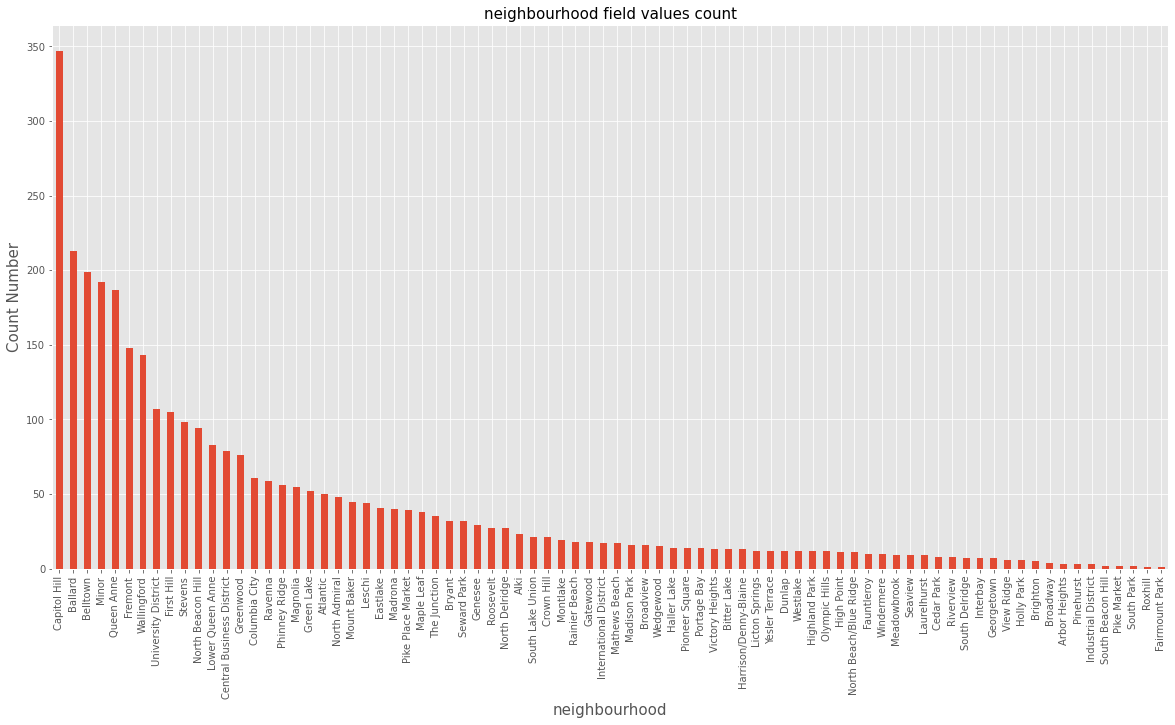

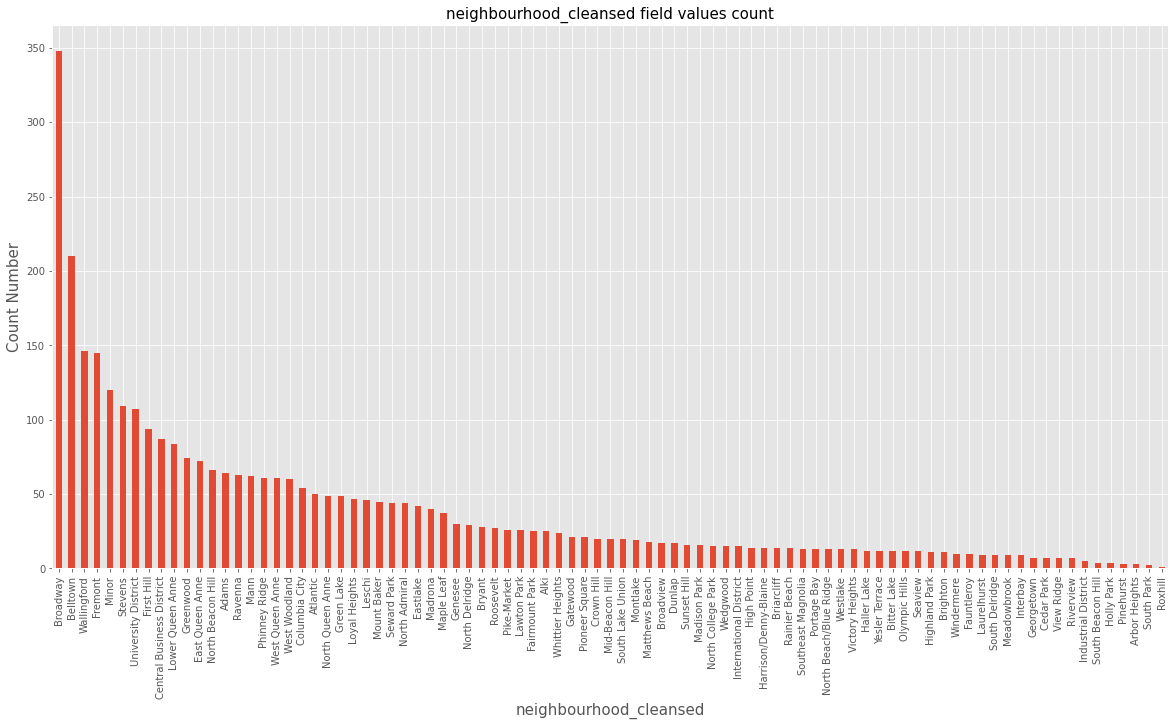

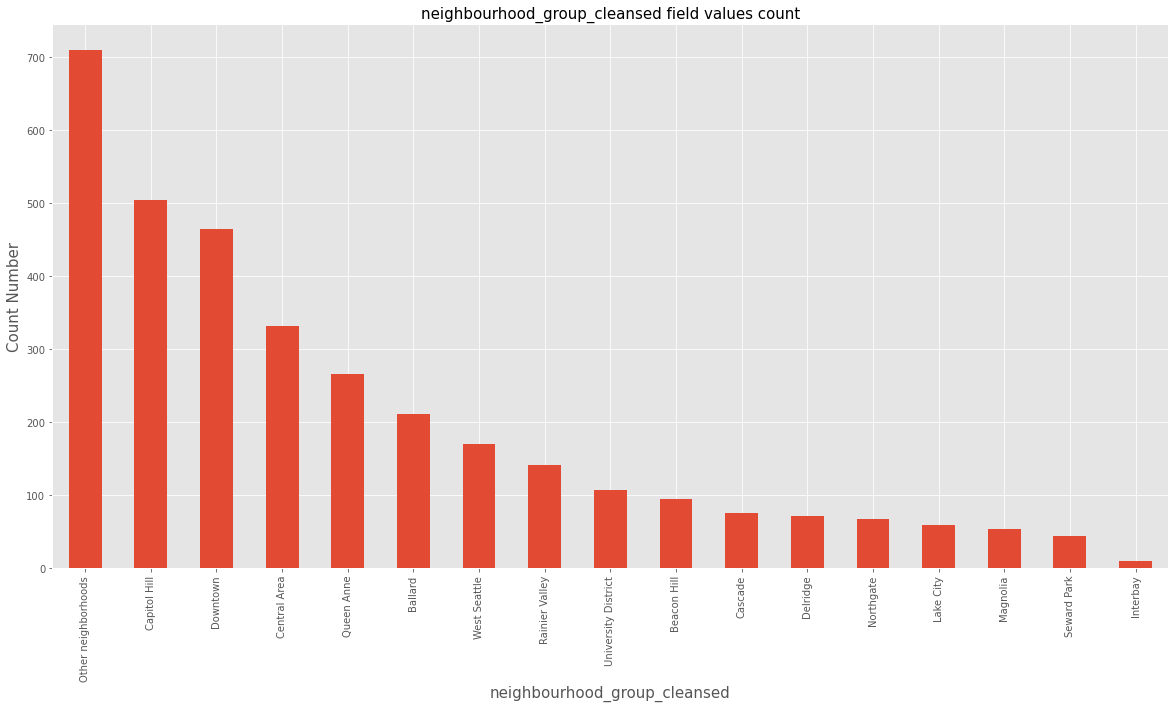

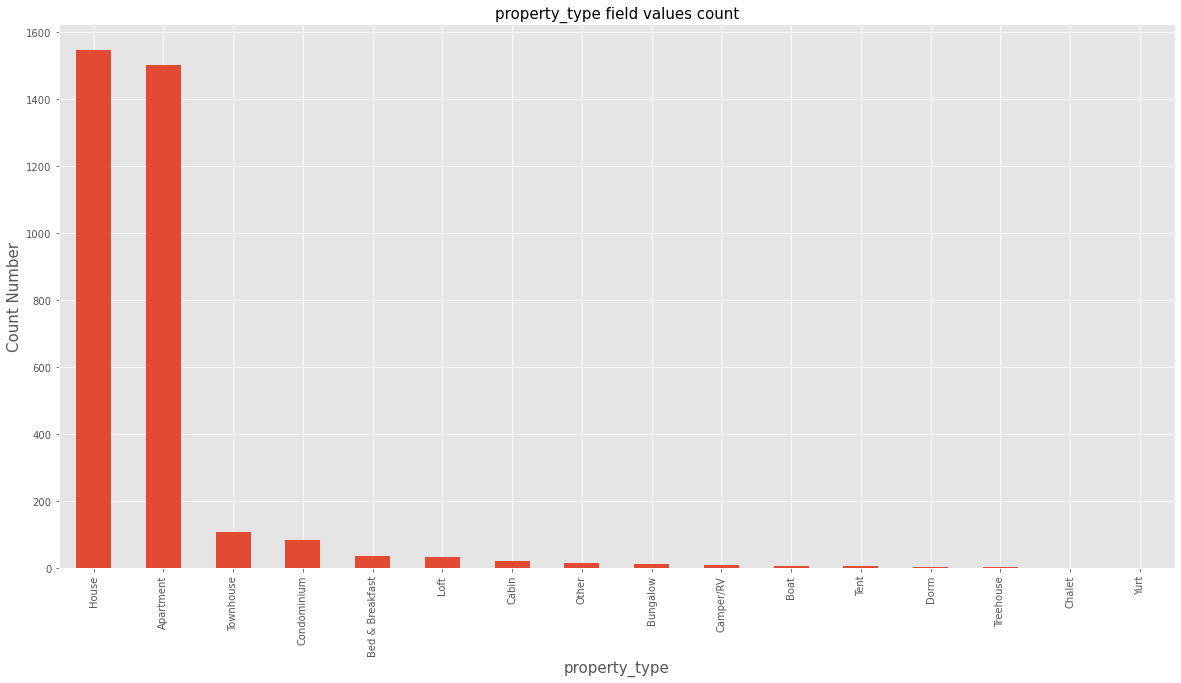

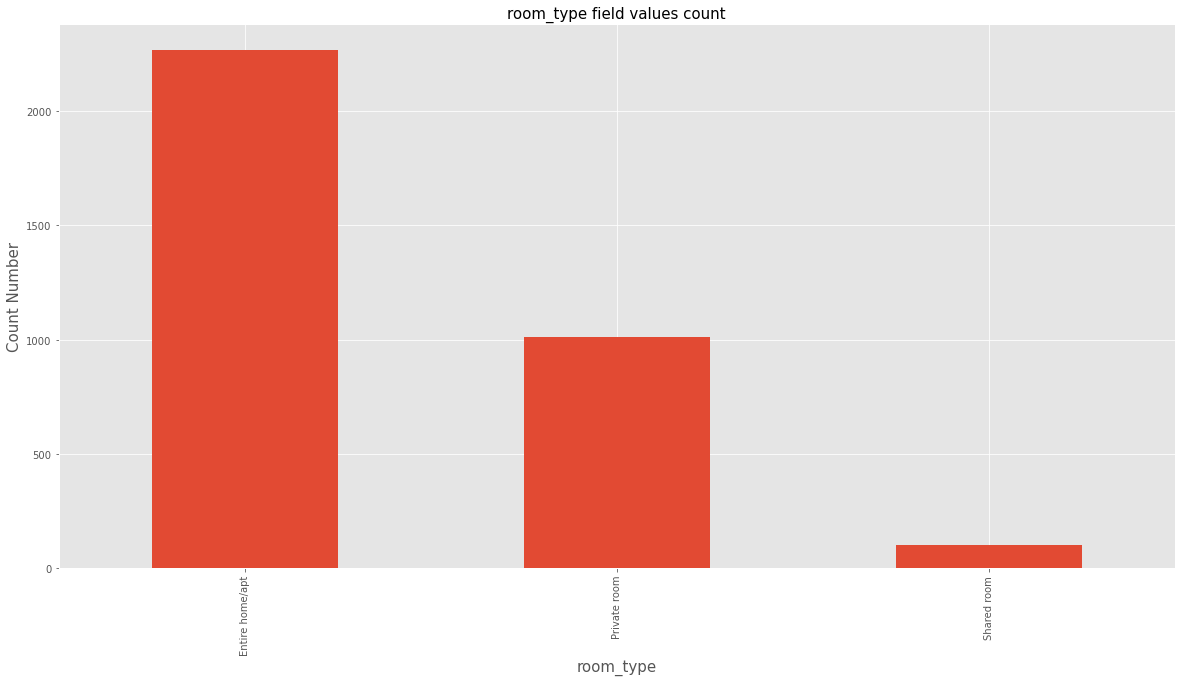

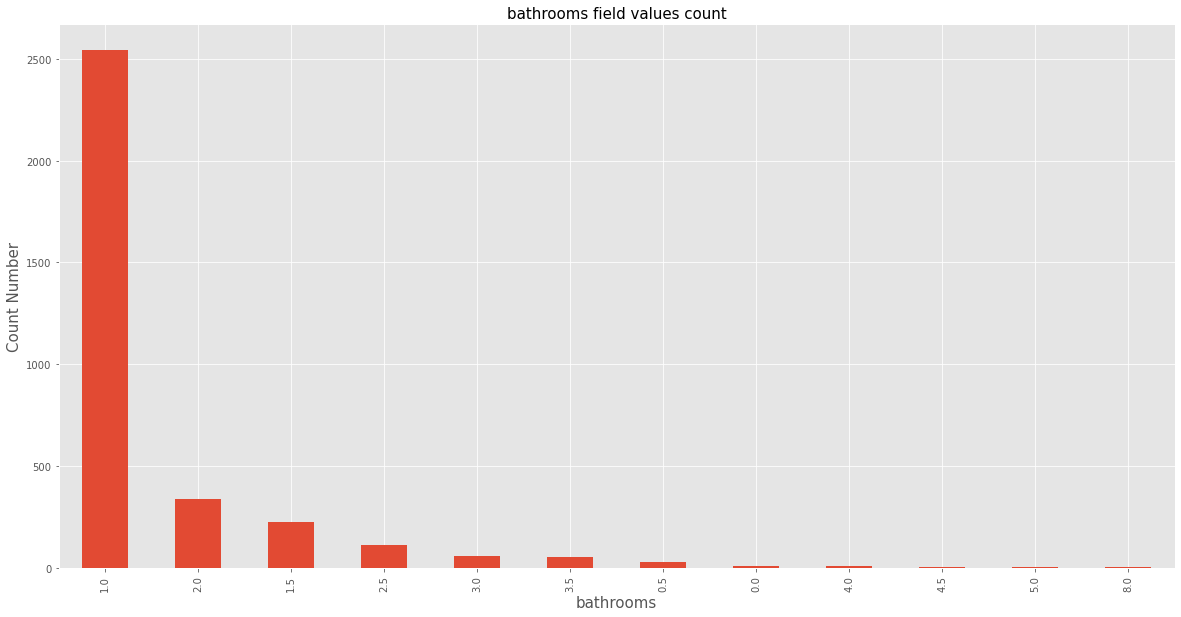

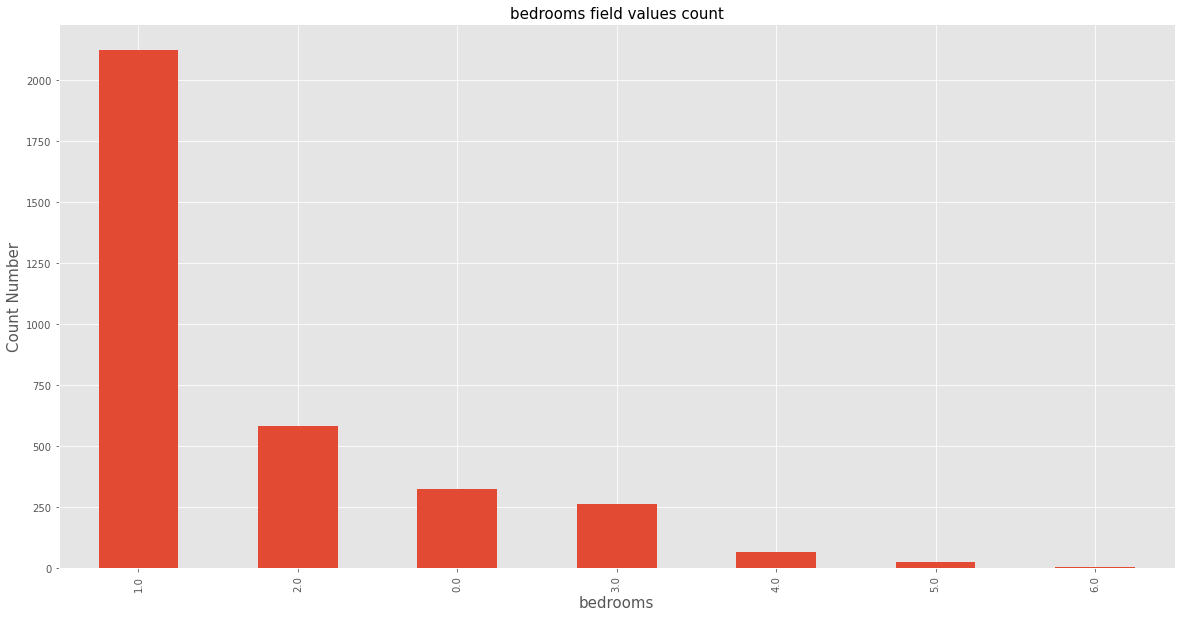

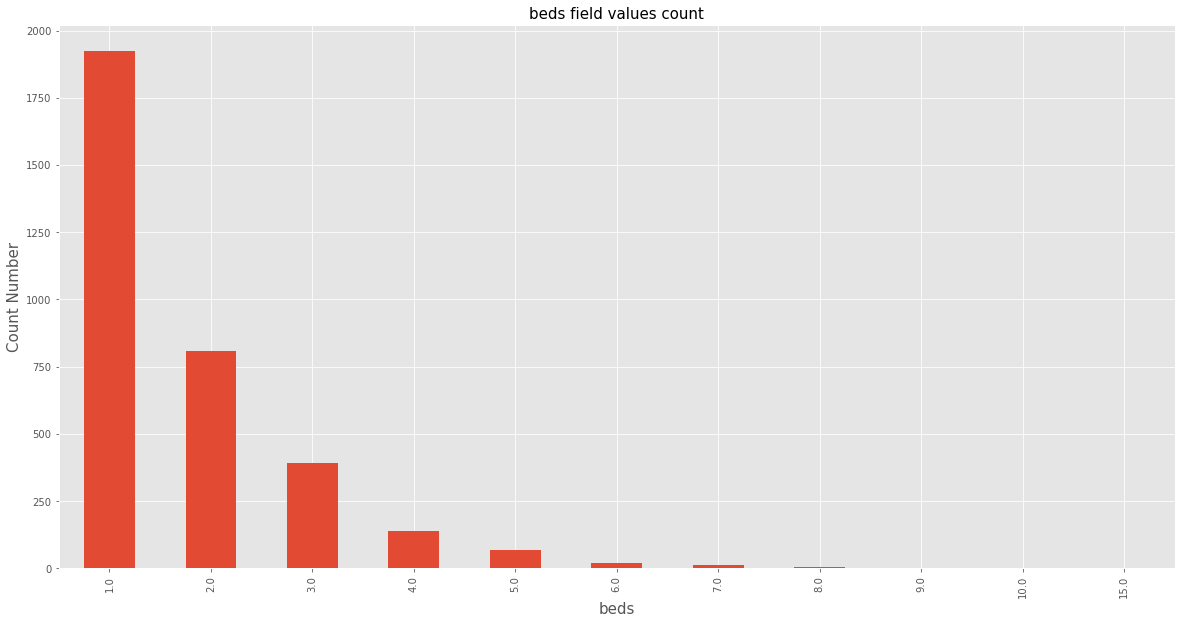

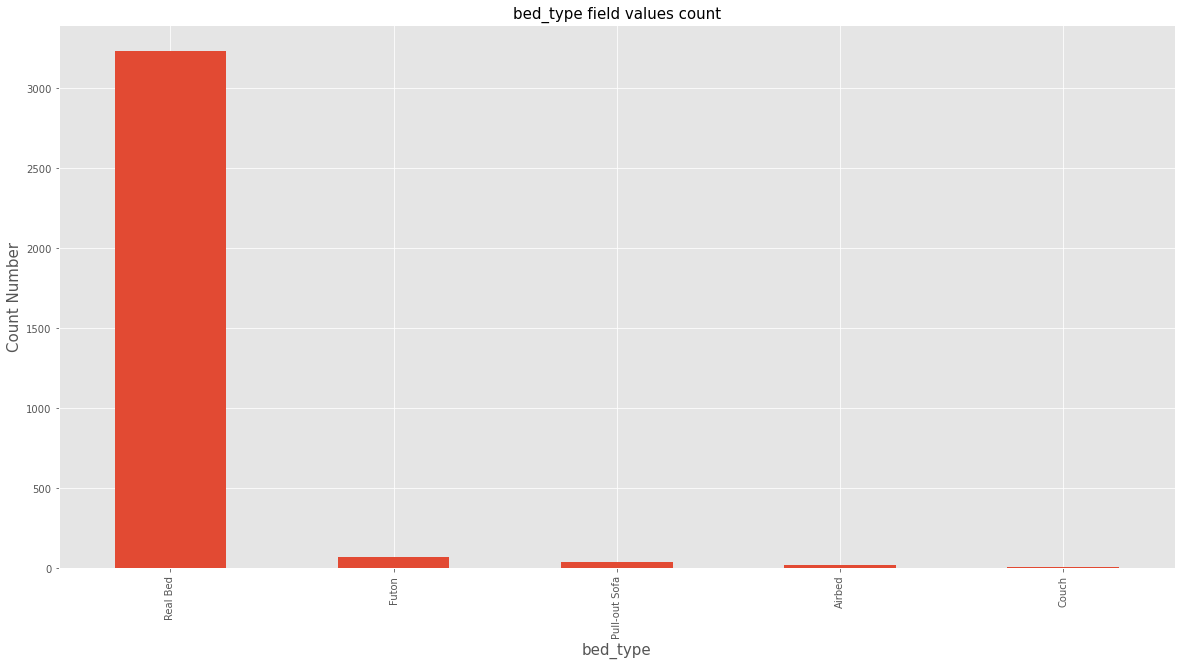

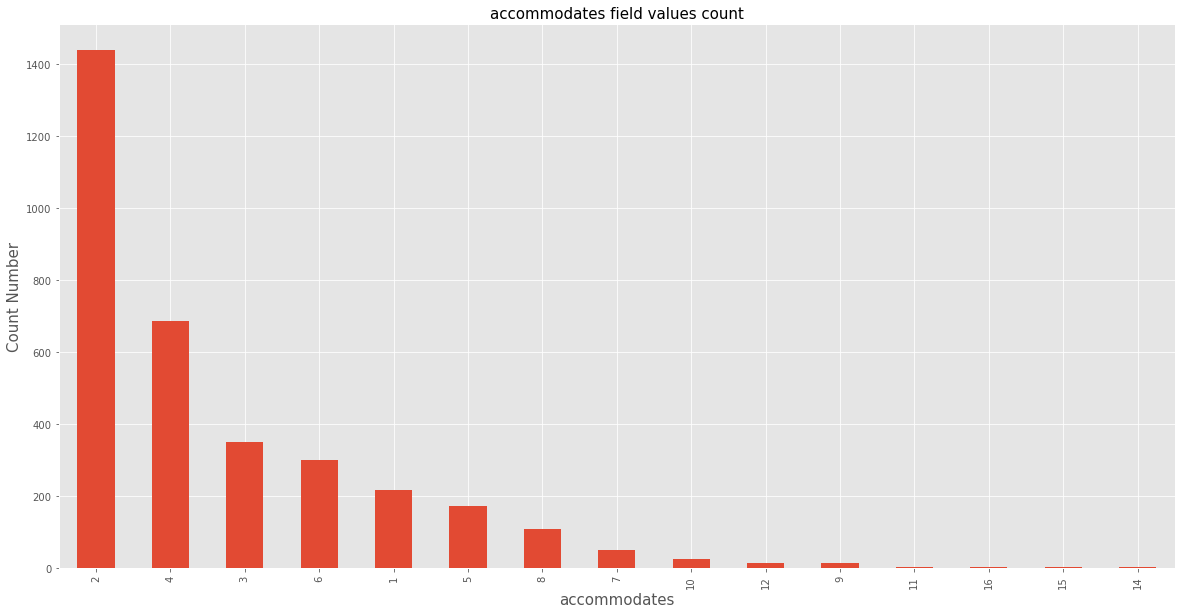

In [30]:
cols = ['neighbourhood', 'neighbourhood_cleansed','neighbourhood_group_cleansed',
        'property_type', 'room_type','bathrooms', 'bedrooms','beds', 'bed_type',
        'accommodates']

for col in cols:
    count_plot(housing,col)

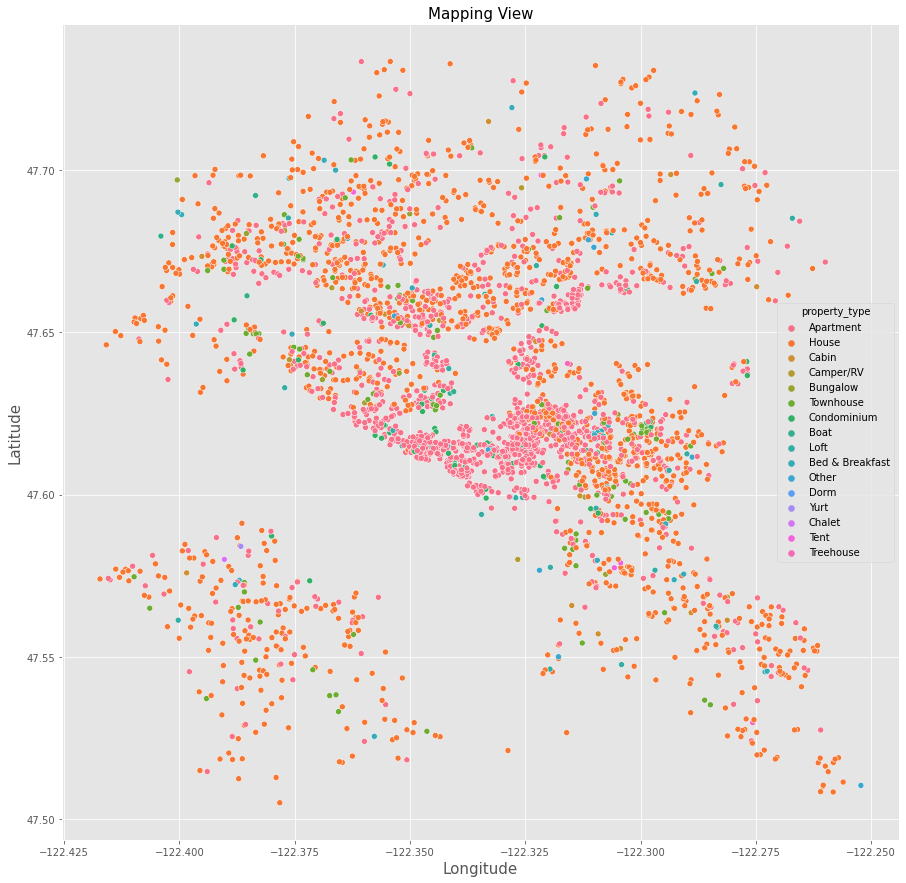

In [31]:
# explore distribution of housing types
fig, ax = plt.subplots(figsize=(15,15))
sns.scatterplot(data=housing, x='longitude',y='latitude', hue='property_type')
plt.title(f'Mapping View', fontsize=15)
ax.set_xlabel('Longitude', fontsize=15)
ax.set_ylabel('Latitude', fontsize=15)
plt.show()

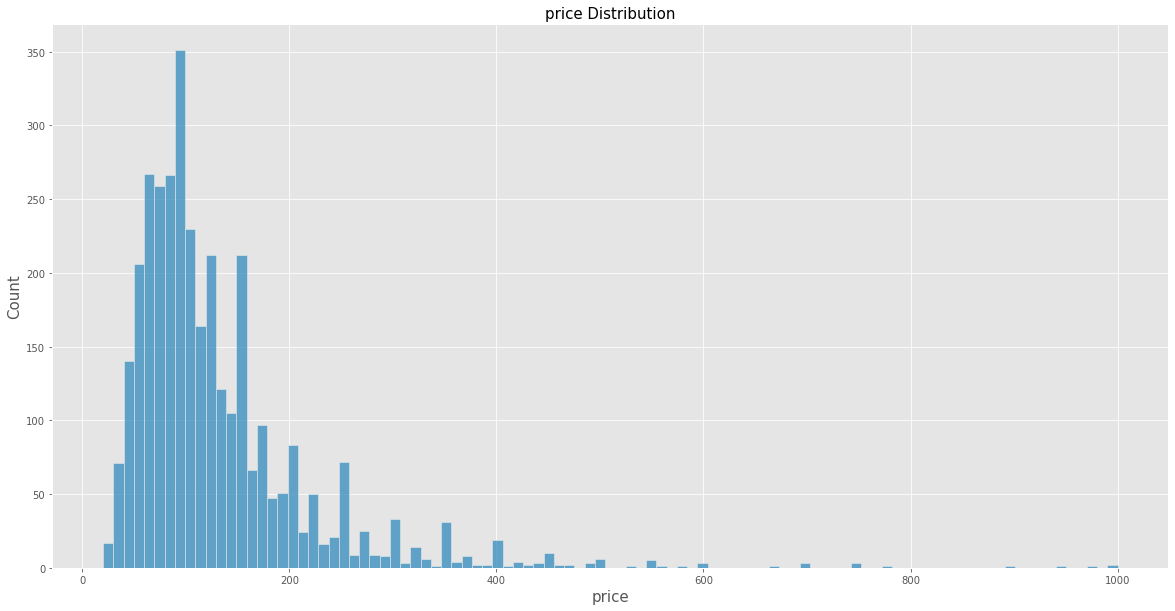

In [32]:
# check the price distribution
hist_plot(housing,'price')

In [33]:
calendar

,listing_id,date,available,price
0,241032,2016-01-04,t,85.0
1,241032,2016-01-05,t,85.0
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN
...,...,...,...,...
1393565,10208623,2016-12-29,f,NaN
1393566,10208623,2016-12-30,f,NaN
1393567,10208623,2016-12-31,f,NaN
1393568,10208623,2017-01-01,f,NaN


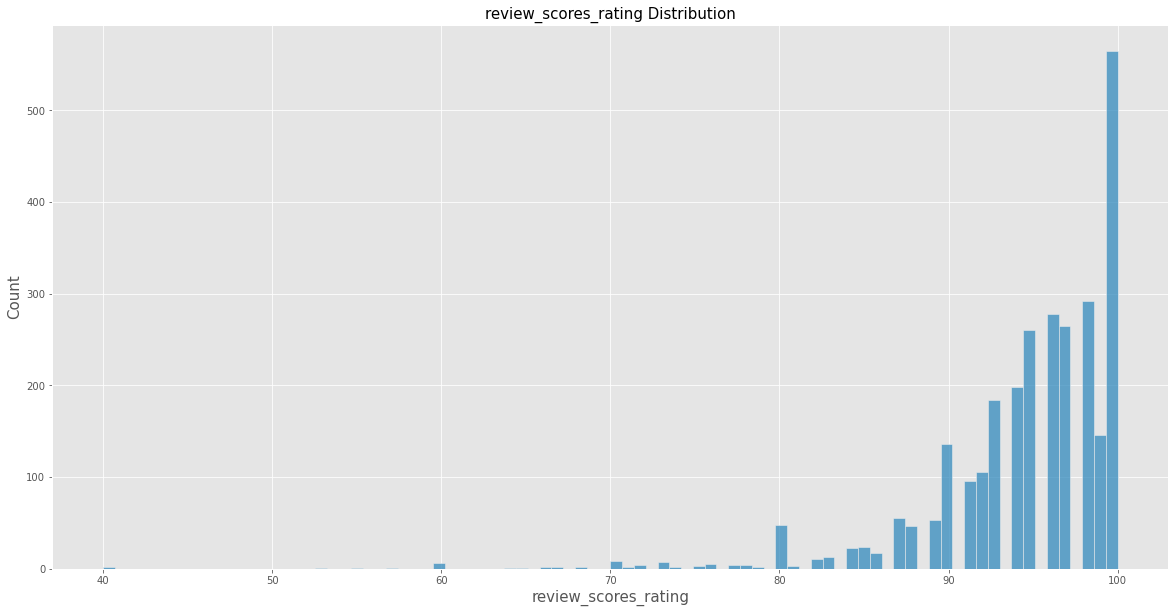

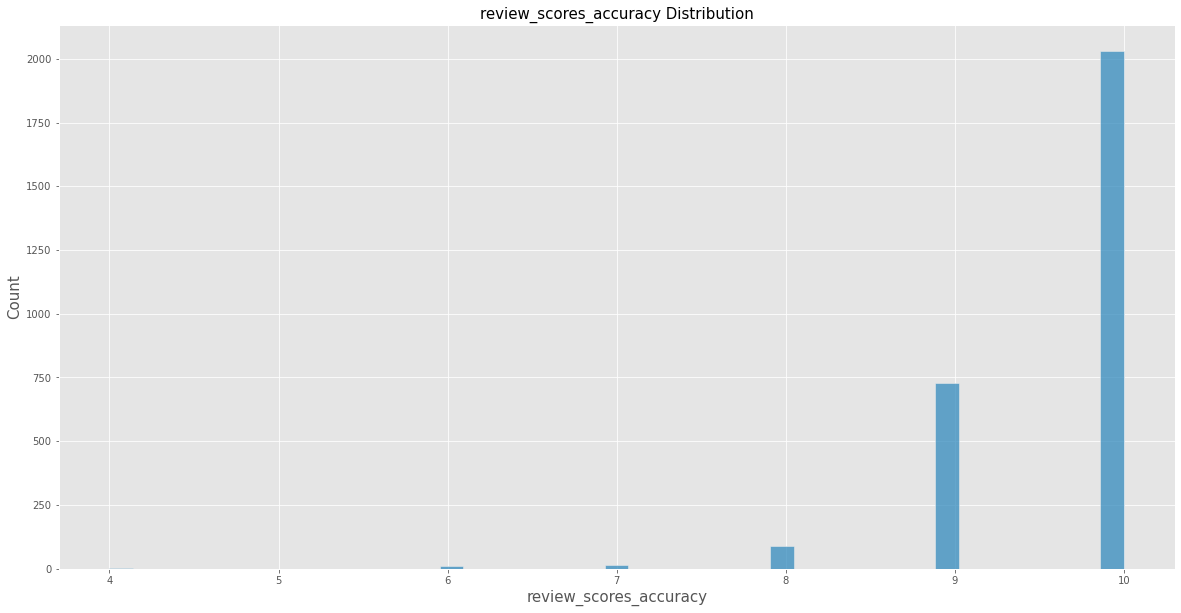

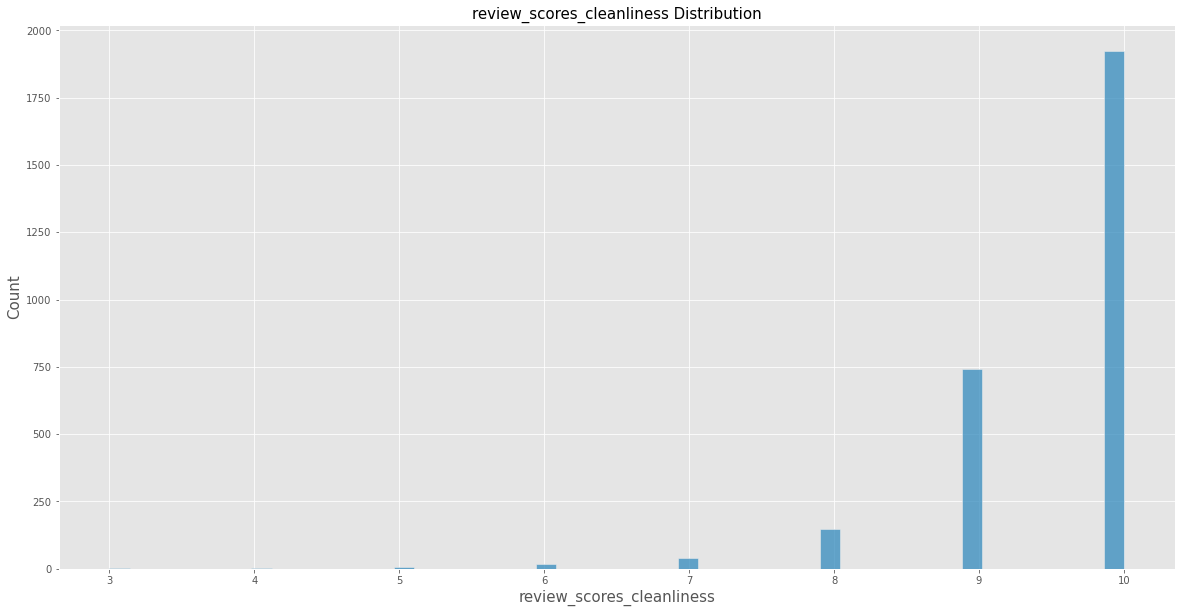

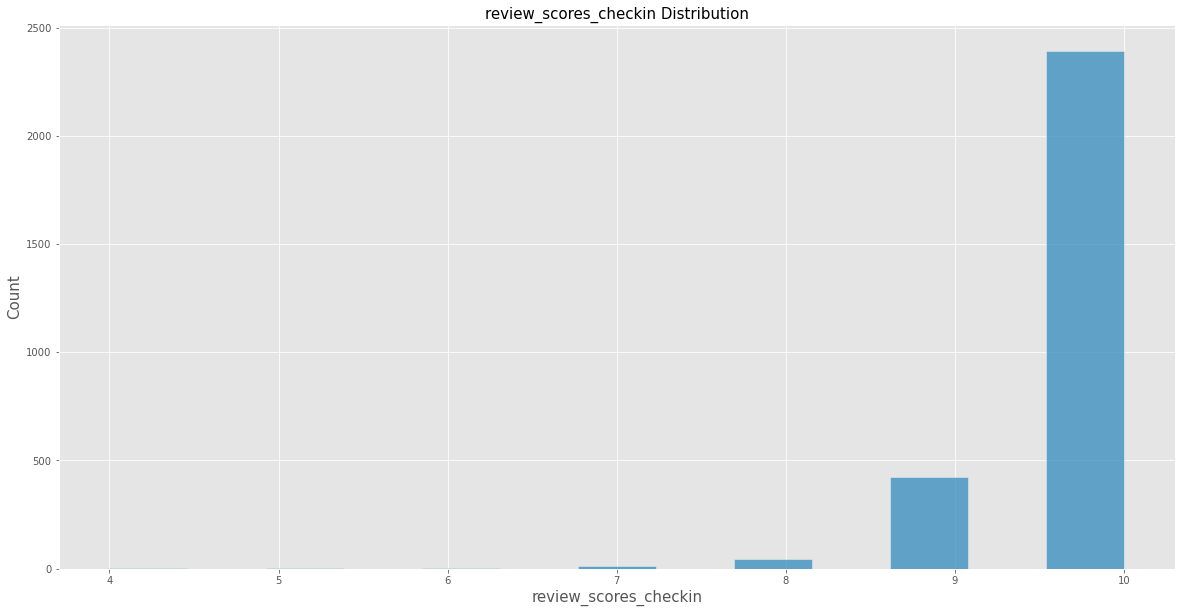

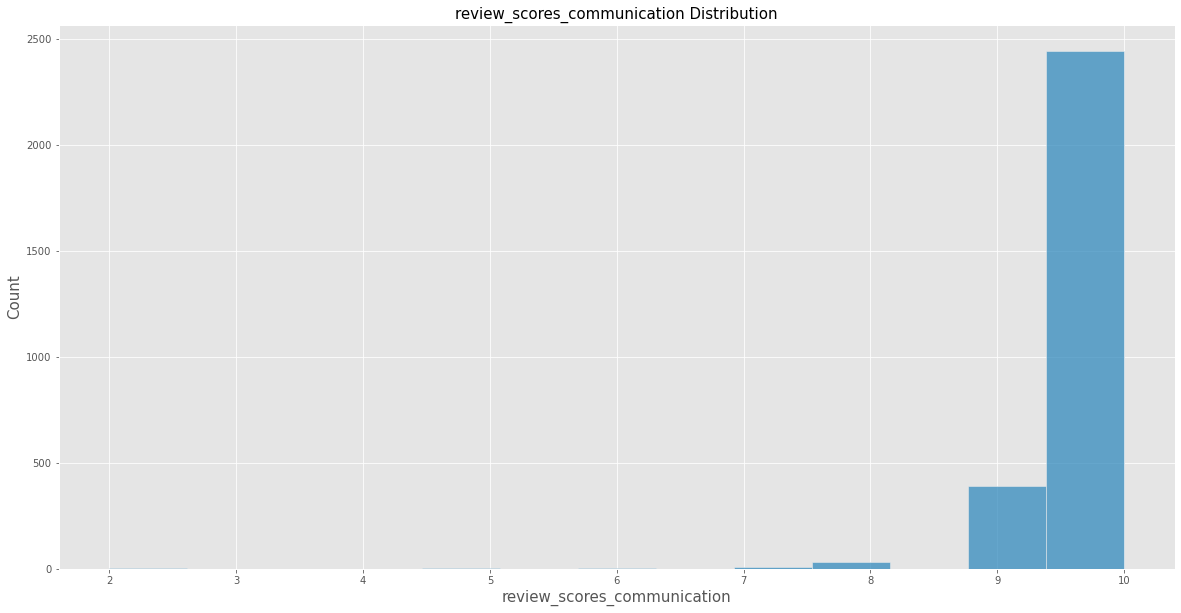

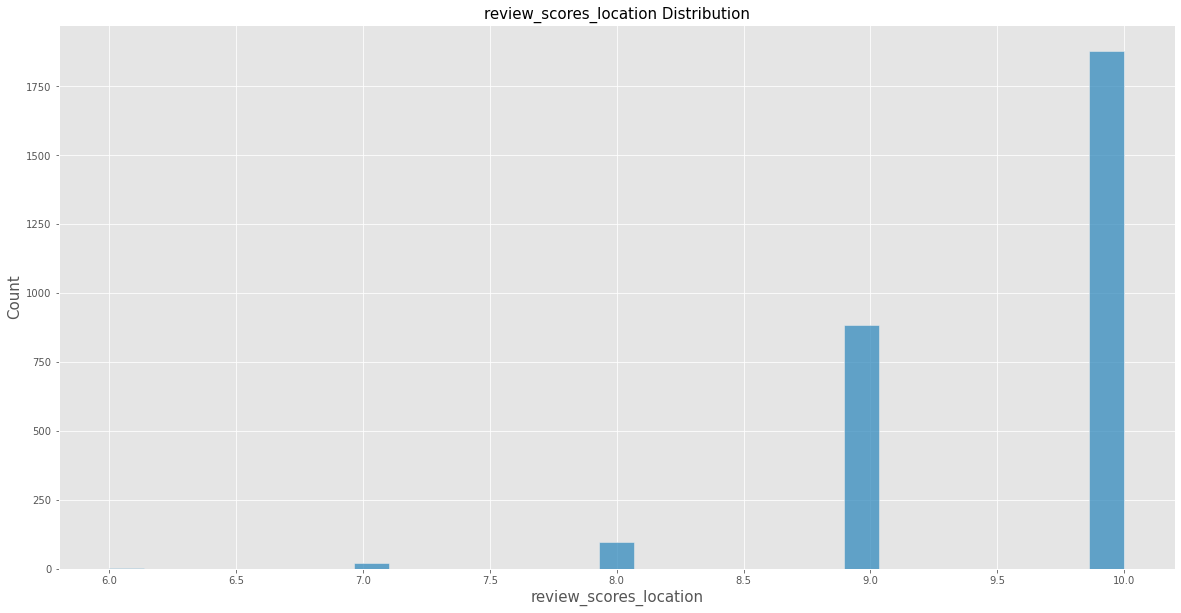

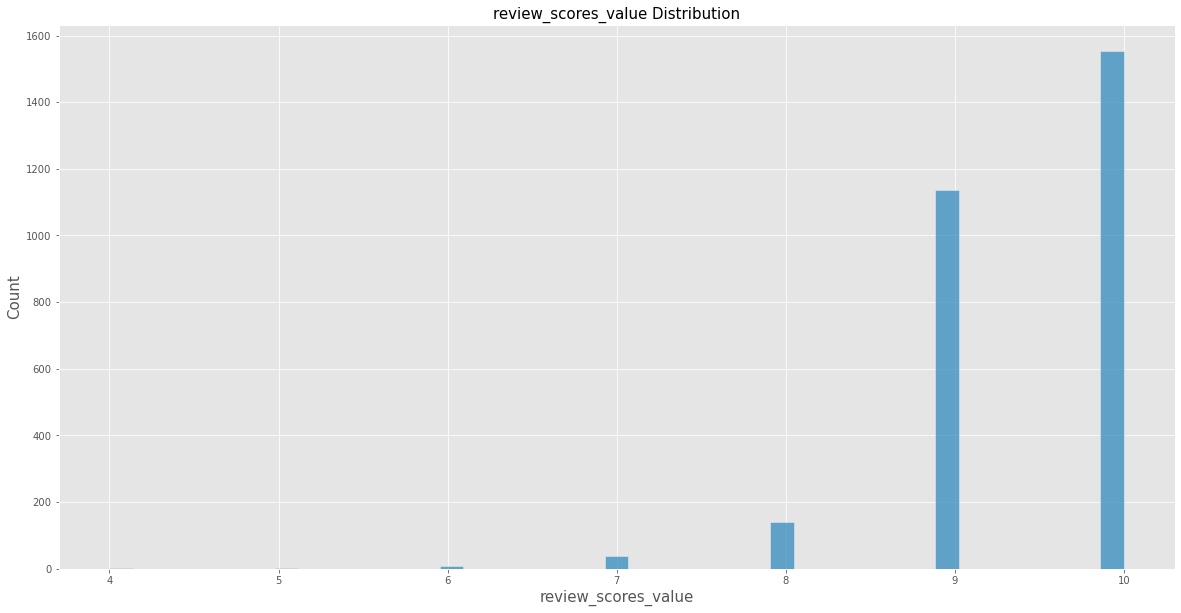

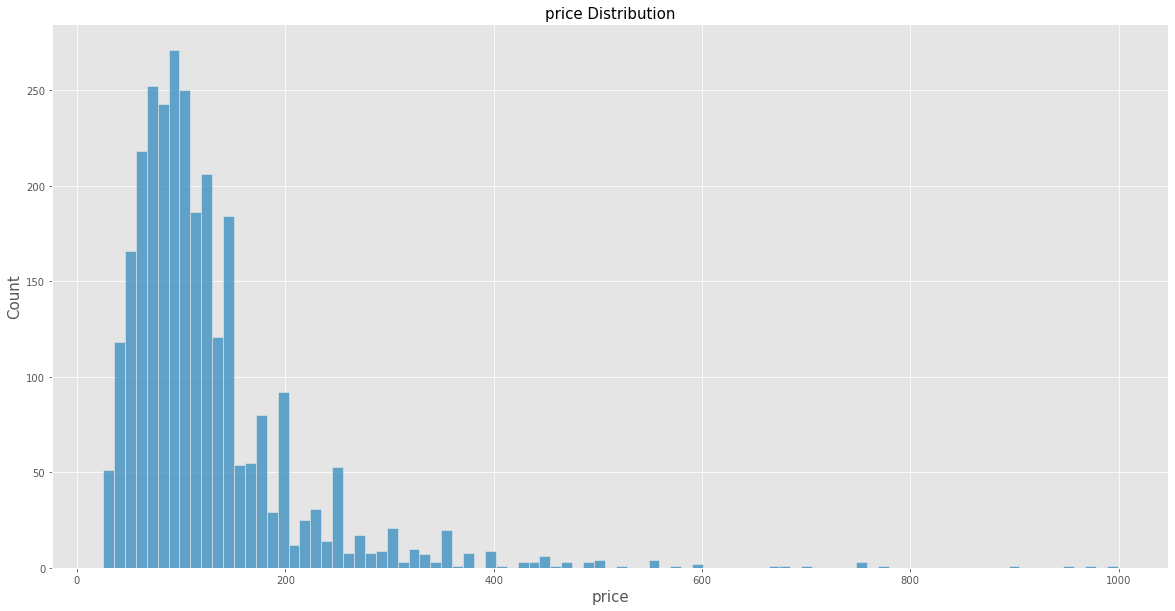

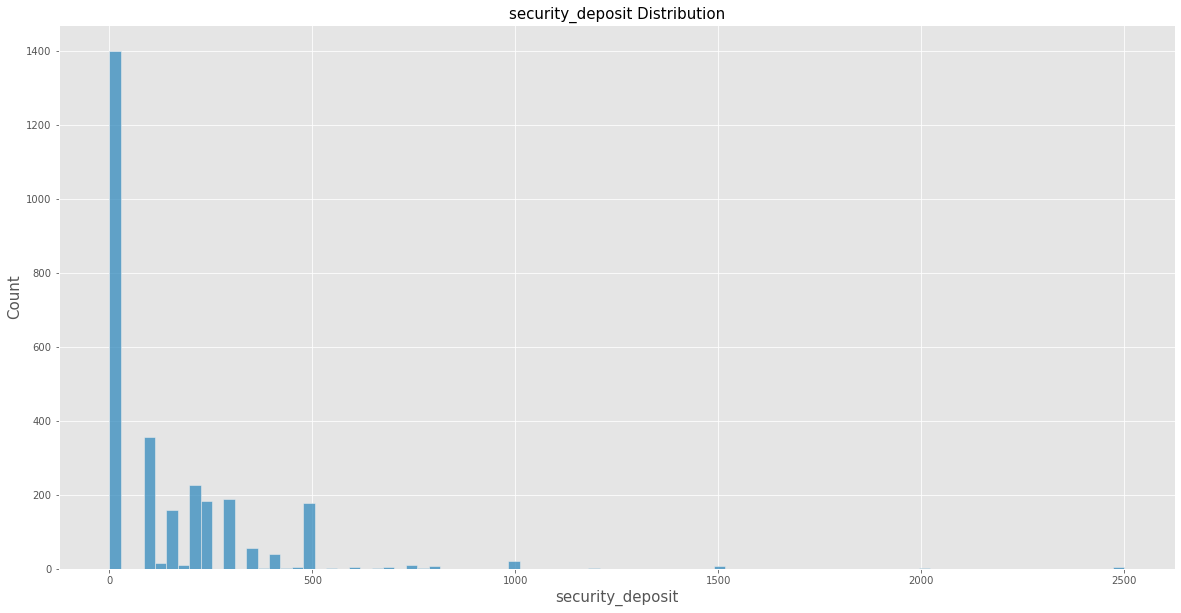

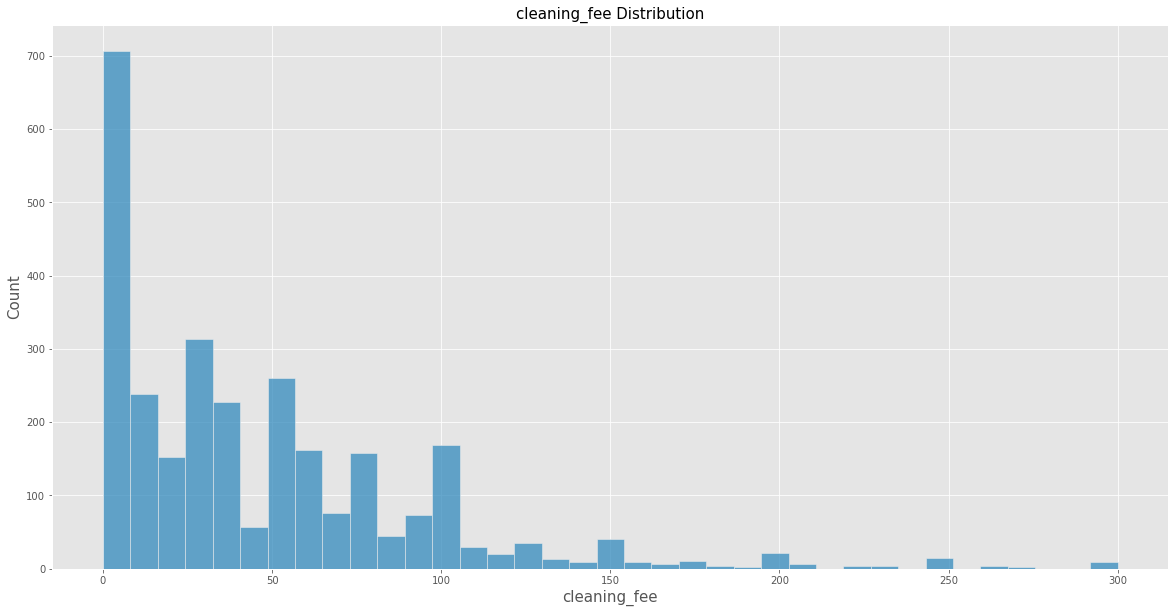

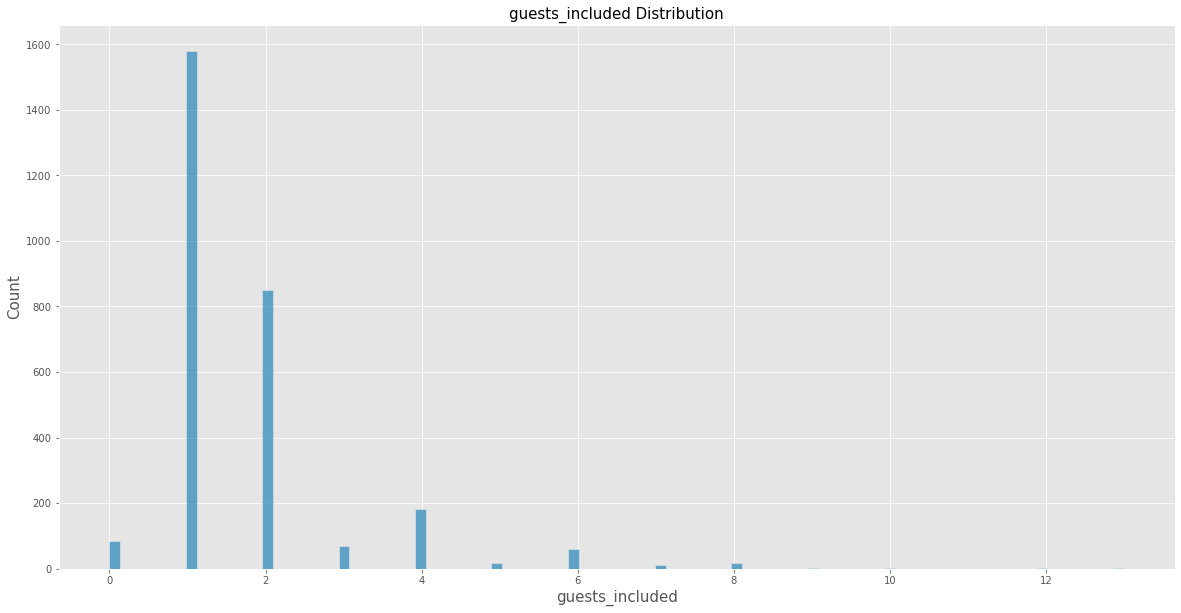

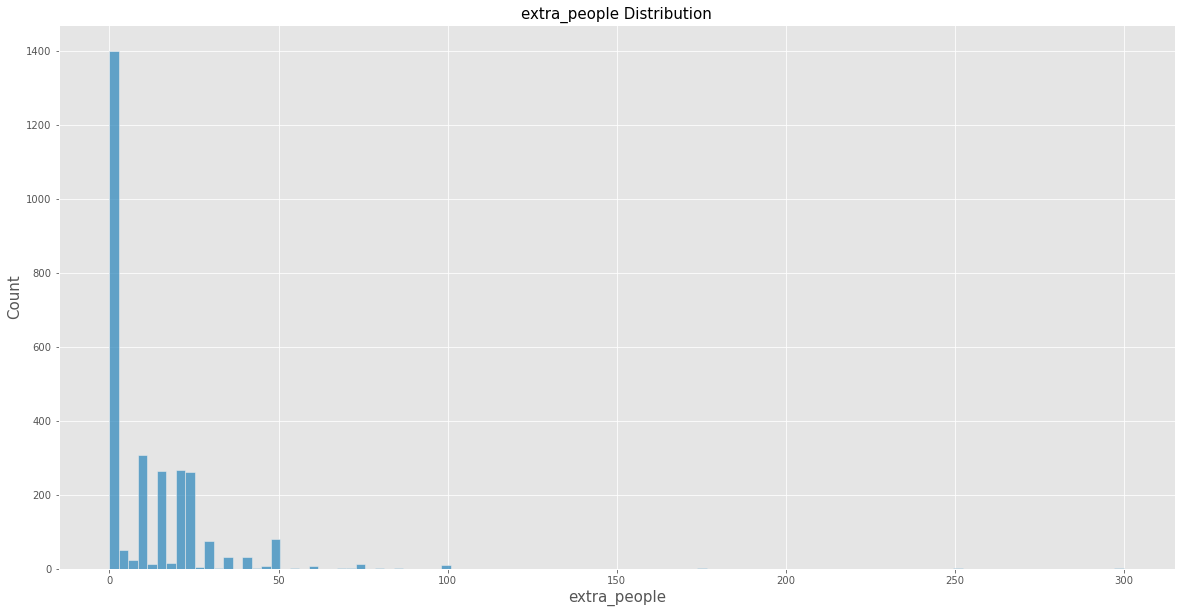

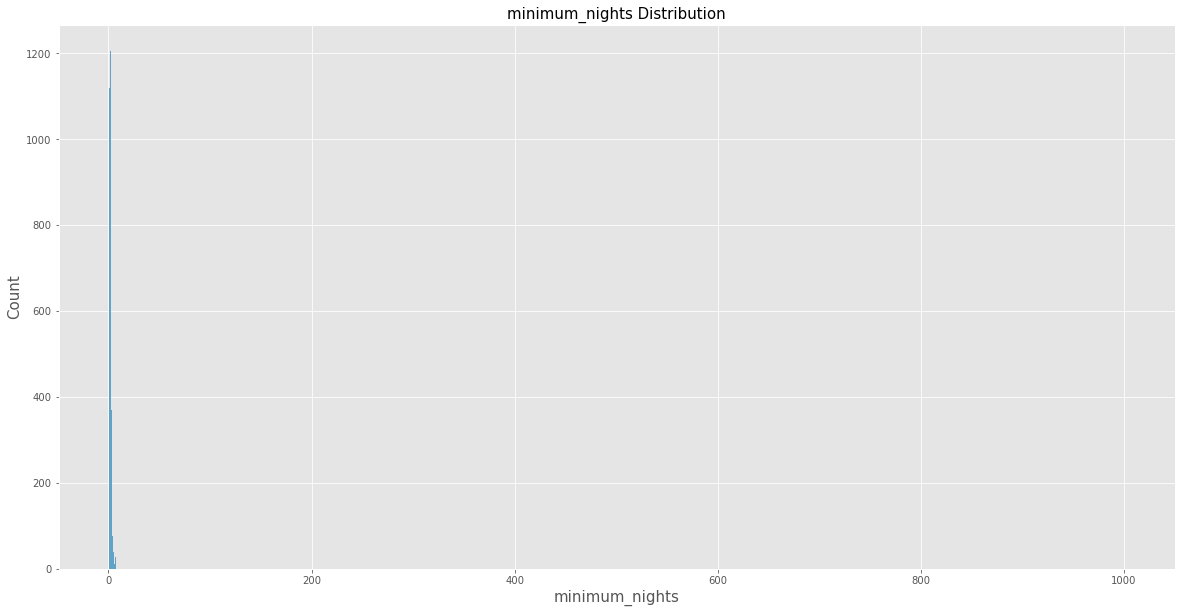

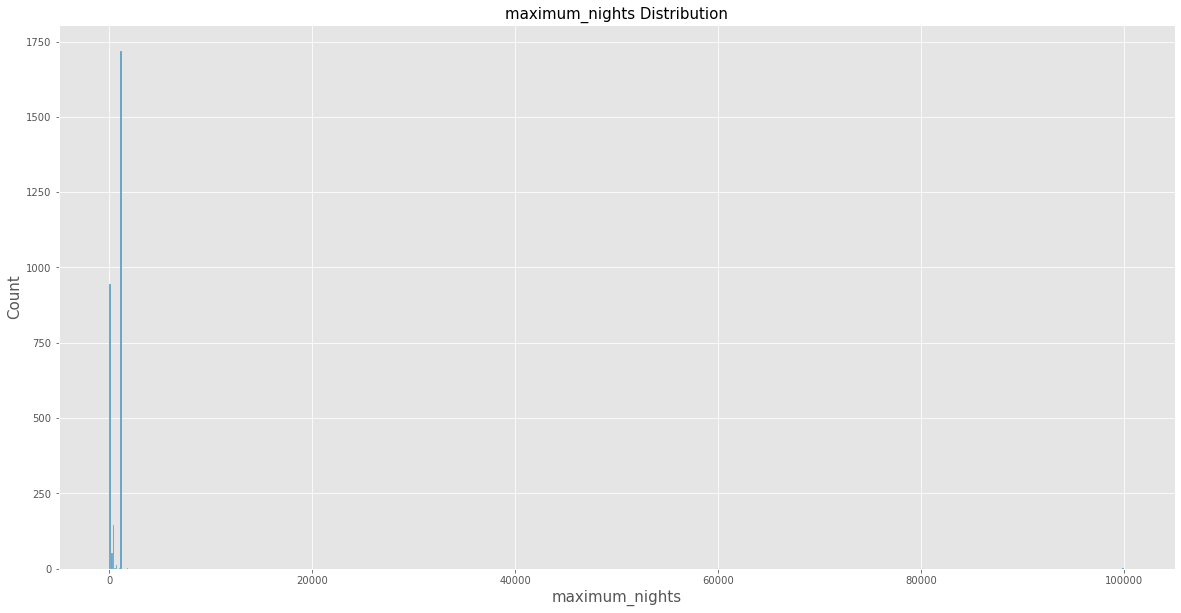

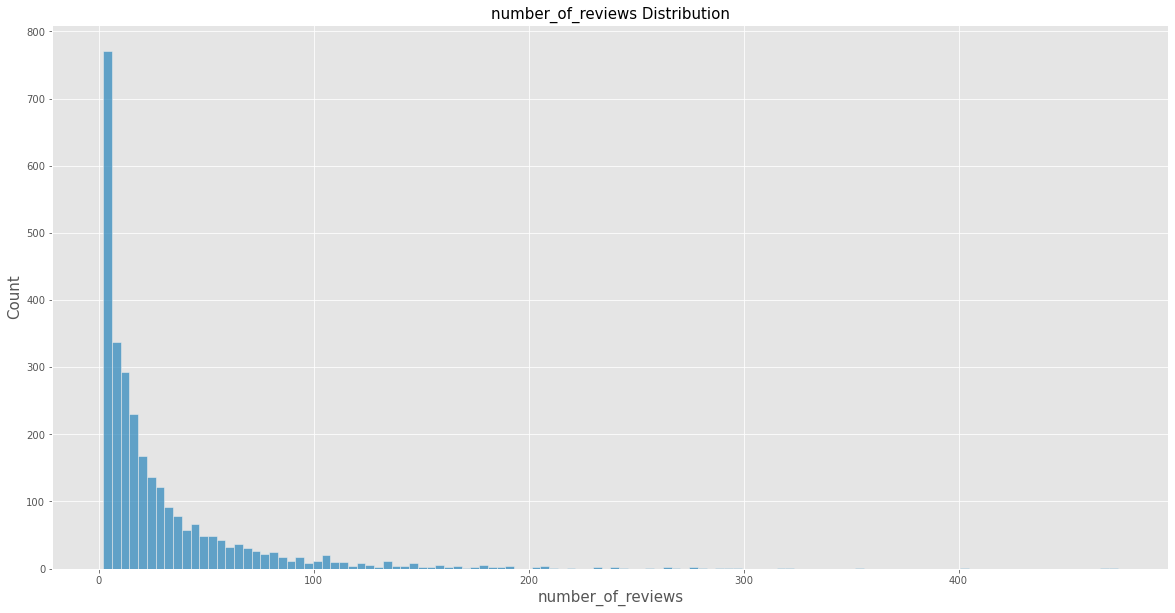

In [34]:
# check the distribution for prices dataset
cols = ['review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'number_of_reviews']
for col in cols:
    hist_plot(prices,col)

In [35]:
# interesting finding for min and max nights requirment
# definitely need to remove those outliers in the analysis
print(prices.minimum_nights.max());print(prices.maximum_nights.max())

1000
100000


### [Housing Types on Airbnb Seattle](#6)<a id="6"></a> <br>

In [36]:
housing.to_excel('housing.xlsx')

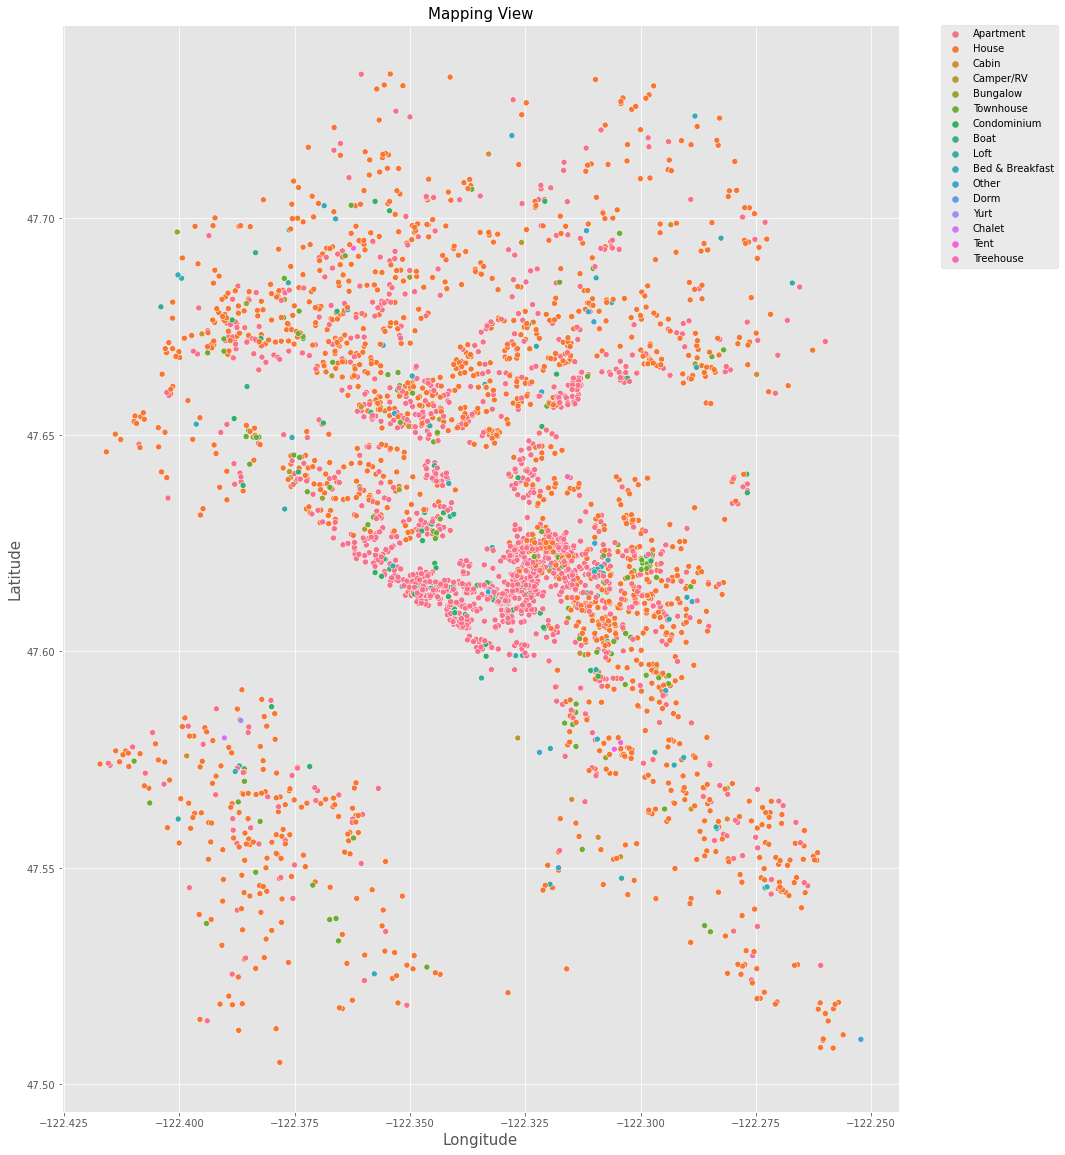

In [37]:
# explore distribution of housing types
fig, ax = plt.subplots(figsize=(15,20))
sns.scatterplot(data=housing, x='longitude',y='latitude', hue='property_type')
plt.title(f'Mapping View', fontsize=15)
ax.set_xlabel('Longitude', fontsize=15)
ax.set_ylabel('Latitude', fontsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

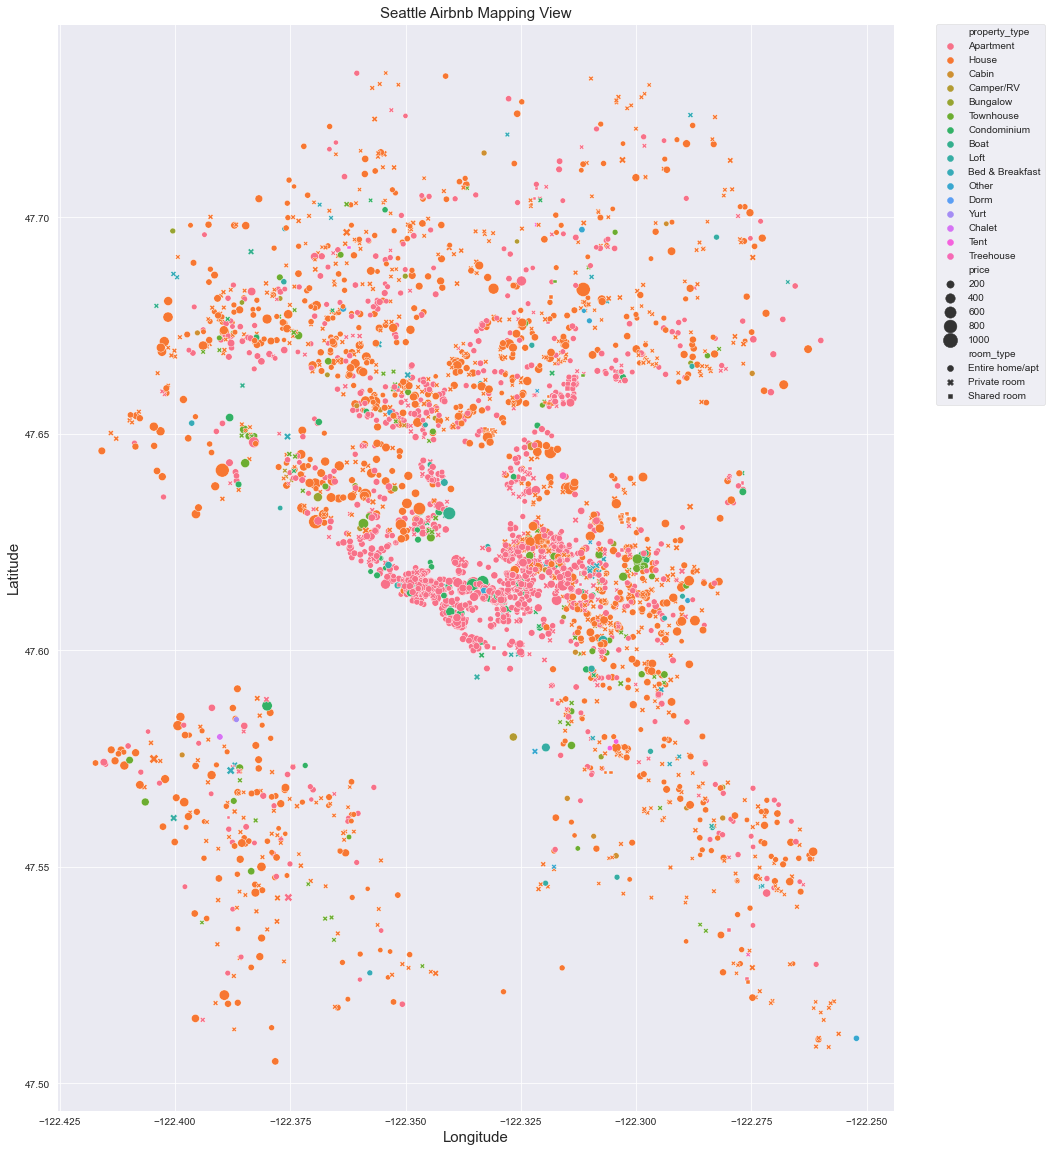

In [49]:
# explore distribution of housing types with characteristics
fig, ax = plt.subplots(figsize=(15,20))
sns.scatterplot(data=housing, x='longitude',y='latitude', hue='property_type', style='room_type',
               size='price', sizes=(20,200))
plt.title(f'Seattle Airbnb Mapping View', fontsize=15)
ax.set_xlabel('Longitude', fontsize=15)
ax.set_ylabel('Latitude', fontsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

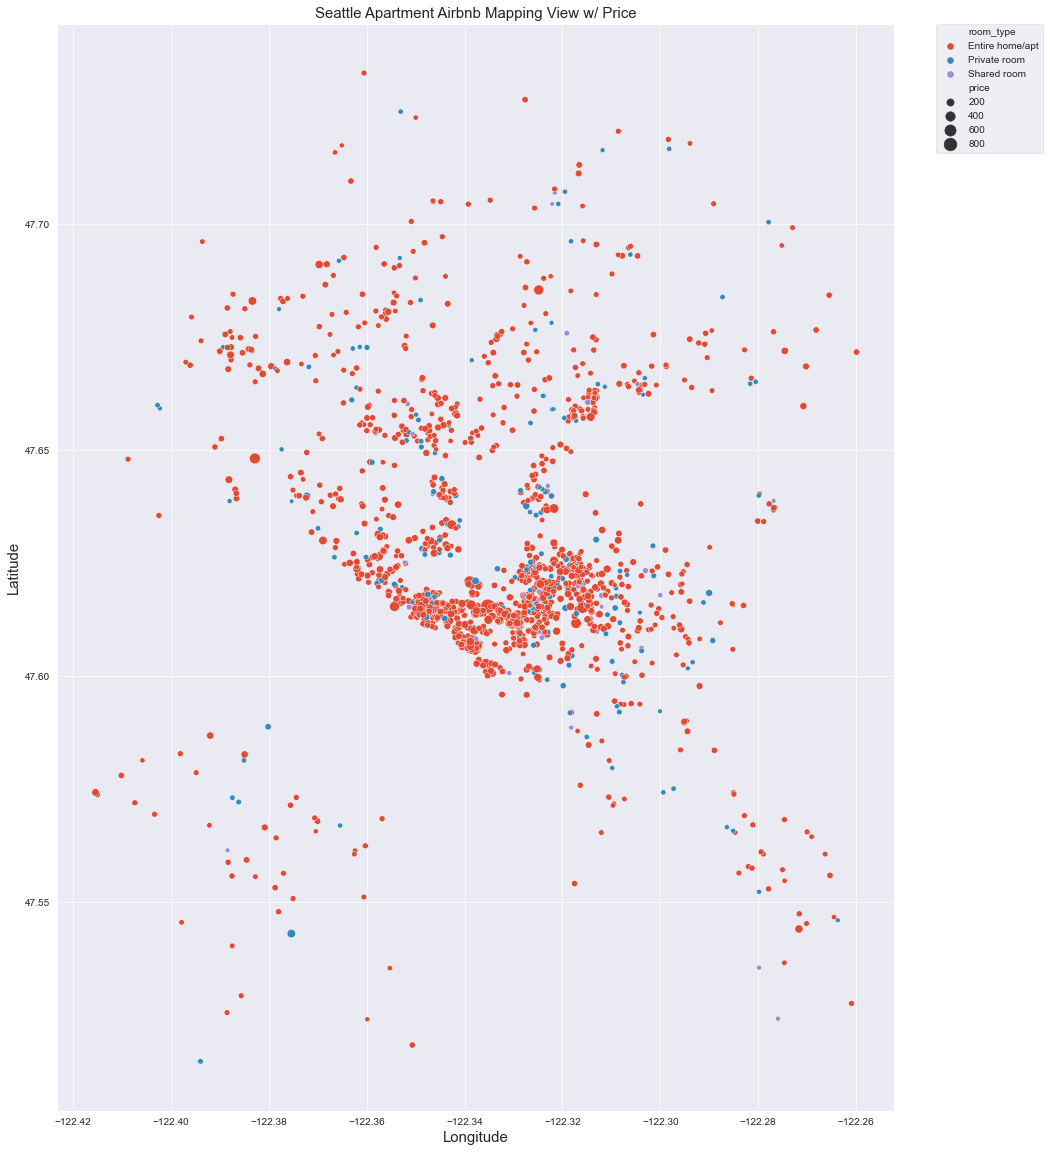

In [52]:
# explore distribution of housing types with characteristics
fig, ax = plt.subplots(figsize=(15,20))
plot_data = housing[housing.property_type == 'Apartment']
sns.scatterplot(data=plot_data, x='longitude',y='latitude', hue='room_type',
               size='price', sizes=(20,200))
plt.title(f'Seattle Apartment Airbnb Mapping View w/ Price', fontsize=15)
ax.set_xlabel('Longitude', fontsize=15)
ax.set_ylabel('Latitude', fontsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

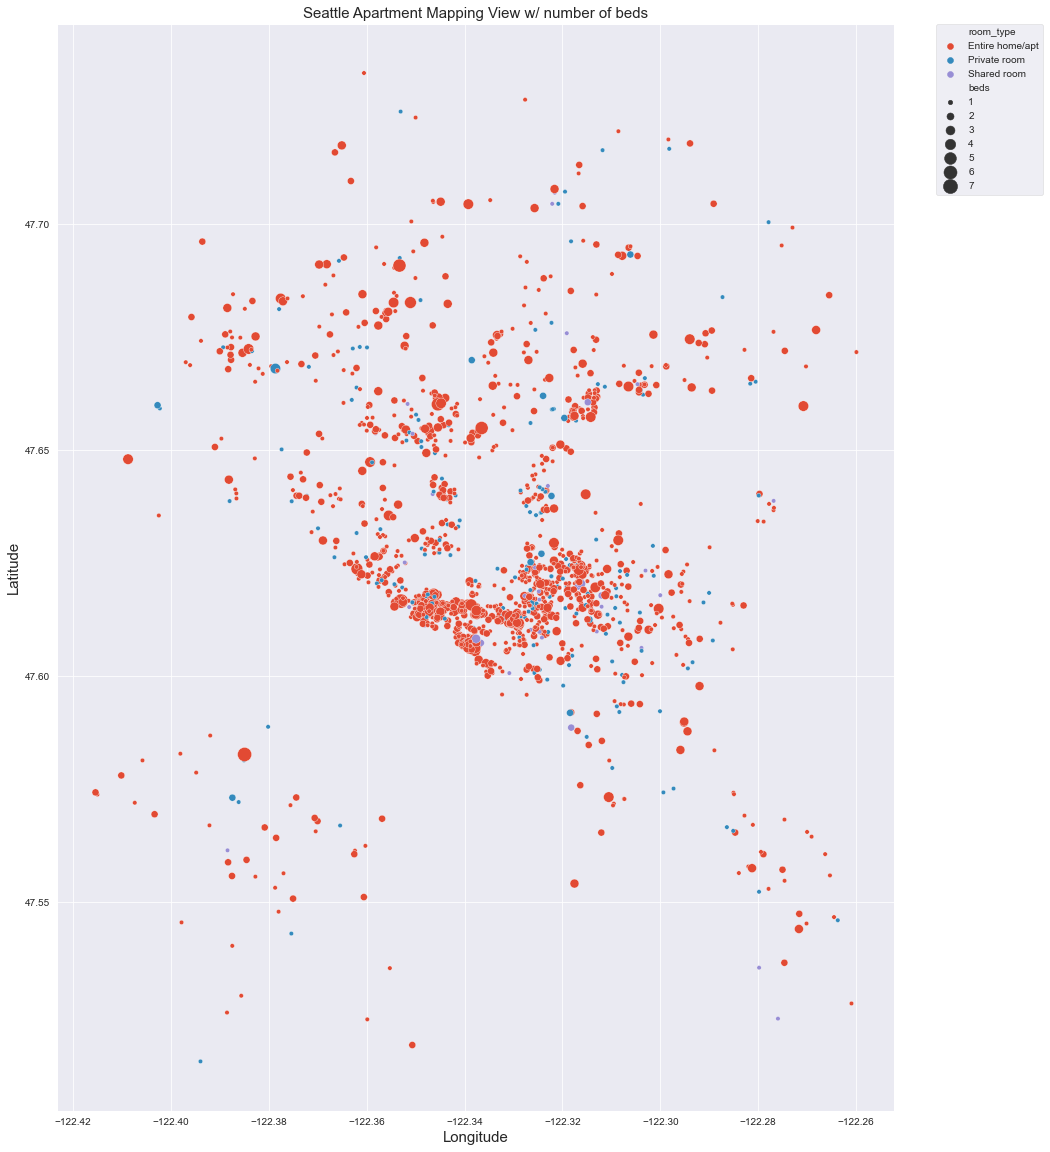

In [51]:
# explore distribution of housing types with characteristics
fig, ax = plt.subplots(figsize=(15,20))
plot_data = housing[housing.property_type == 'Apartment']
sns.scatterplot(data=plot_data, x='longitude',y='latitude', hue='room_type',
               size='beds', sizes=(20,200))
plt.title(f'Seattle Apartment Mapping View w/ number of beds', fontsize=15)
ax.set_xlabel('Longitude', fontsize=15)
ax.set_ylabel('Latitude', fontsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

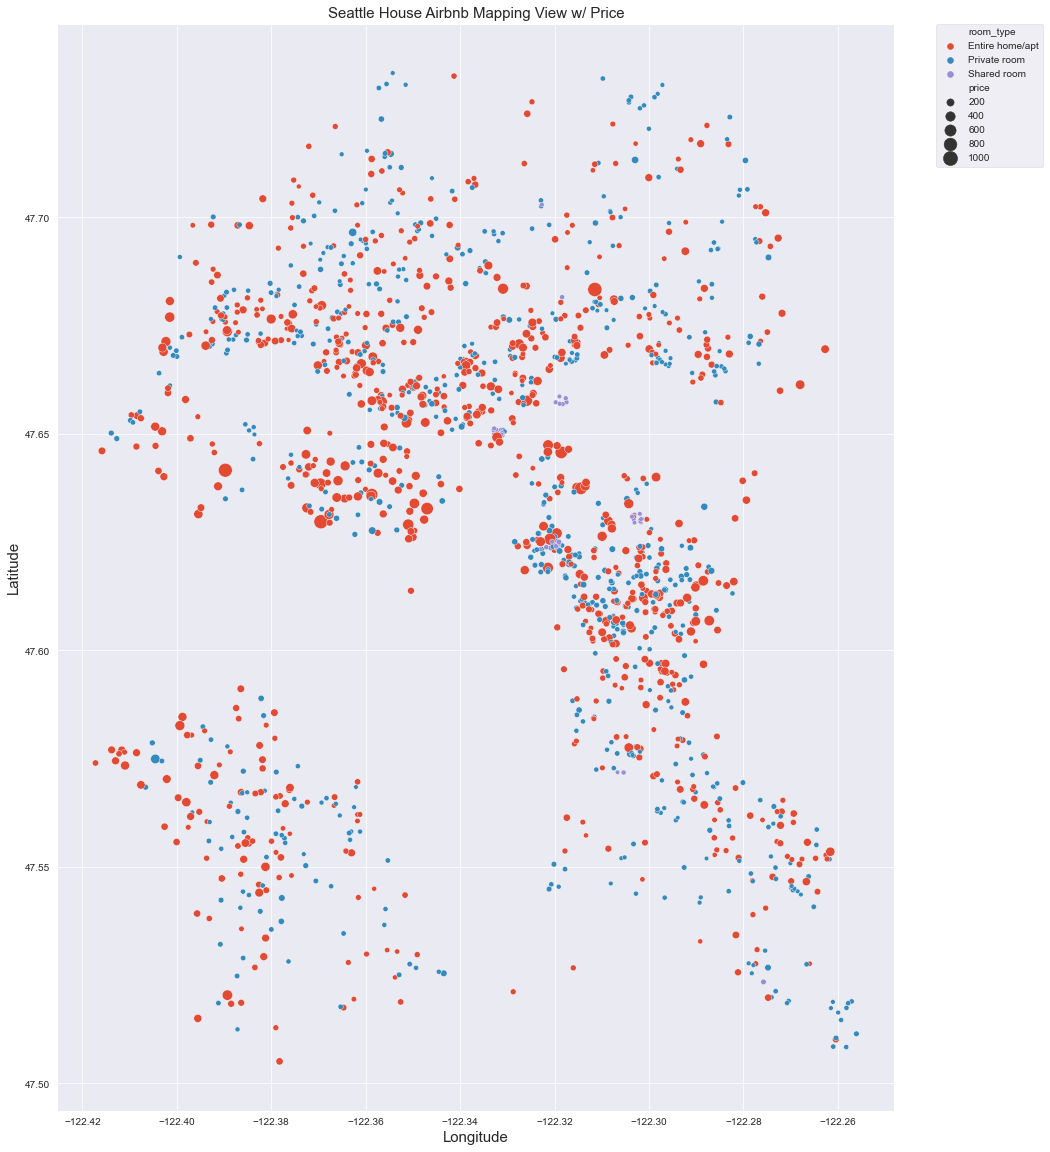

In [53]:
# explore distribution of housing types with characteristics
fig, ax = plt.subplots(figsize=(15,20))
plot_data = housing[housing.property_type == 'House']
sns.scatterplot(data=plot_data, x='longitude',y='latitude', hue='room_type',
               size='price', sizes=(20,200))
plt.title(f'Seattle House Airbnb Mapping View w/ Price', fontsize=15)
ax.set_xlabel('Longitude', fontsize=15)
ax.set_ylabel('Latitude', fontsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

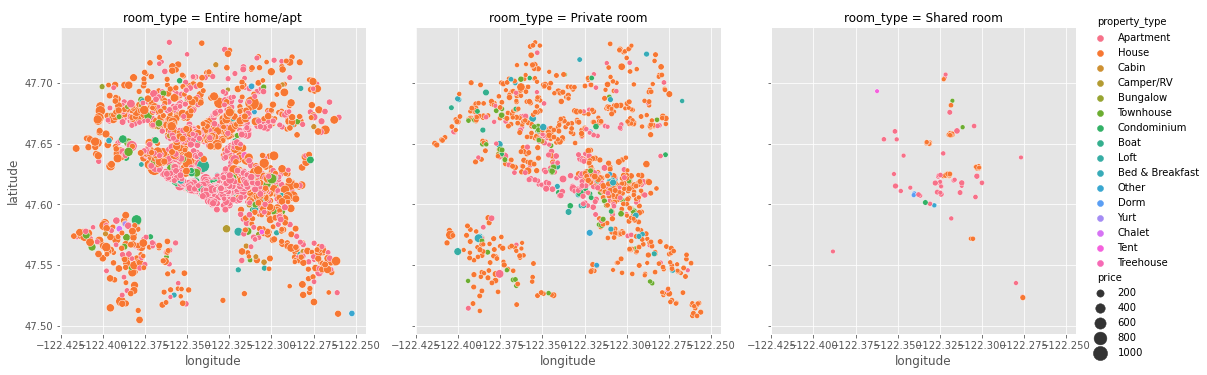

In [42]:
# explore distribution of housing types by separating room types
sns.relplot(data=housing, x='longitude',y='latitude', 
            col='room_type', hue='property_type', 
            size='price', sizes=(20,200))
ax.set_xlabel('Longitude', fontsize=15)
ax.set_ylabel('Latitude', fontsize=15)
plt.show()

### [Airbnb Popularity in Seattle](#7)<a id="7"></a> <br>

In [43]:
# calculate the availbility rate each month
df = calendar.copy()
df1 = df[df.available == 't'].groupby('date').agg({'available':'count'})
df2 = df.groupby('date').agg({'available':'count'})

In [44]:
df2.rename(columns={"available": "total"}, inplace=True)
df1 = df1.merge(df2, on='date')

In [45]:
df1['booked'] = df1.total - df1.available
df1['occupied_rate'] = (df1.booked / df1.total) * 100
df1.reset_index(inplace=True)
df1['date'] = pd.to_datetime(df1['date'])
df1

,date,available,total,booked,occupied_rate
0,2016-01-04,1735,3818,2083,54.557360
1,2016-01-05,1867,3818,1951,51.100052
2,2016-01-06,1826,3818,1992,52.173913
3,2016-01-07,1776,3818,2042,53.483499
4,2016-01-08,1782,3818,2036,53.326349
...,...,...,...,...,...
360,2016-12-29,2835,3818,983,25.746464
361,2016-12-30,2840,3818,978,25.615506
362,2016-12-31,2859,3818,959,25.117863
363,2017-01-01,2922,3818,896,23.467784


In [46]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           365 non-null    datetime64[ns]
 1   available      365 non-null    int64         
 2   total          365 non-null    int64         
 3   booked         365 non-null    int64         
 4   occupied_rate  365 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 14.4 KB


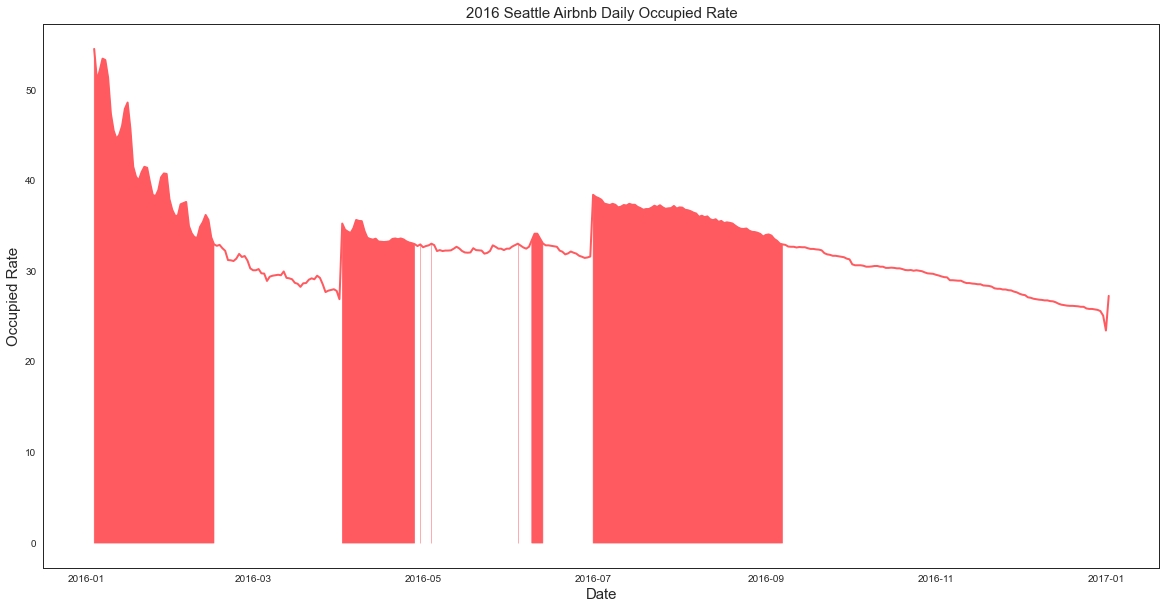

In [102]:
# explore distribution of housing types
sns.set_style('white')
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=df1, x='date',y='occupied_rate', color='#FF5A5F', linewidth=2)
plt.title(f'2016 Seattle Airbnb Daily Occupied Rate', fontsize=15)
ax.set_xlabel('Date', fontsize=15)
ax.set_ylabel('Occupied Rate', fontsize=15)
avg_rate = df1.occupied_rate.mean()
#ax.axhline(avg_rate, color='#FC642D', lw=2)
ax.fill_between(df1['date'], df1['occupied_rate'],where=df1['occupied_rate']>avg_rate, color='#FF5A5F')
plt.show()

obtain major dates:
- 2016-01-04 to 2016-02-16
- 2016-04-02 to 2016-04-30
- 2016-06-09 to 2016-06-13
- 2016-07-01 to 2016-09-07

In [48]:
# find the specific range of dates that airbnb are booked abover average rate in Seattle
date_list = []
for i in range(0,365):
    if df1.loc[i, 'occupied_rate'] >= avg_rate:
        date_list.append(df1.loc[i, 'date'])
        
# print(date_list)

In [72]:
# prepare data for lineplots
df3 = df1.drop(columns=['occupied_rate','total'])
df4 = pd.melt(df3, id_vars = ['date'], var_name='type', value_name='count')
df4.head(3)

,date,type,count
0,2016-01-04,available,1735
1,2016-01-05,available,1867
2,2016-01-06,available,1826


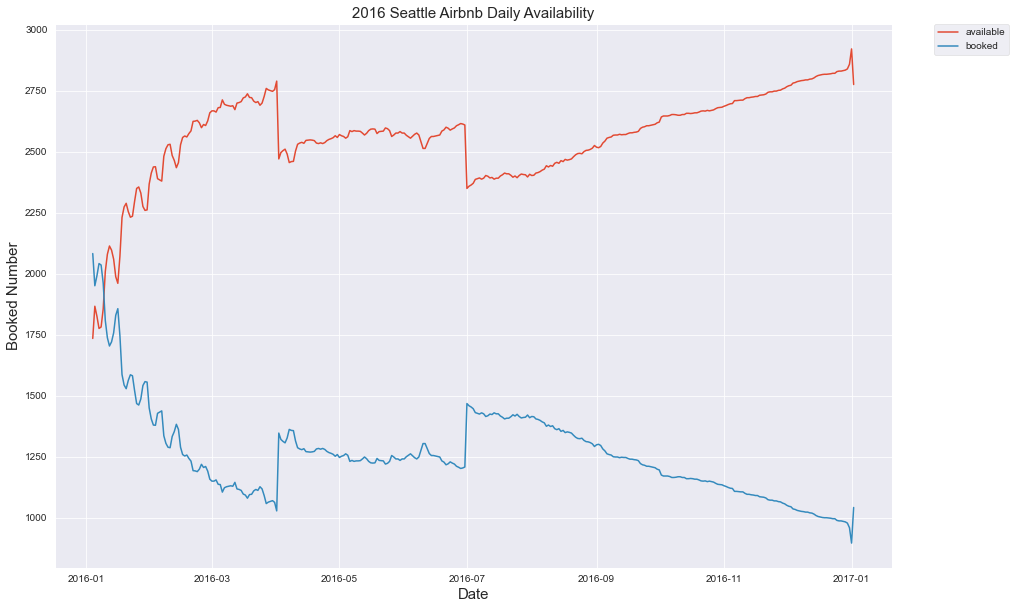

In [74]:
# explore distribution of housing types
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(15,10))
sns.lineplot(data=df4, x='date',y='count', hue='type')
plt.title(f'2016 Seattle Airbnb Daily Availability', fontsize=15)
ax.set_xlabel('Date', fontsize=15)
ax.set_ylabel('Booked Number', fontsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### [Listing Prices & Review Scores](#8)<a id="8"></a> <br>

In [159]:
prices.head(3).transpose()

,0,1,2
id,241032,953595,3308979
host_is_superhost,f,t,f
review_scores_rating,95,96,97
review_scores_accuracy,10,10,10
review_scores_cleanliness,10,10,10
review_scores_checkin,10,10,10
review_scores_communication,10,10,10
review_scores_location,9,10,10
review_scores_value,10,10,10
price,85,150,975


In [201]:
# get summary statistics of host and superhost data
data = prices.copy()

# remove outliers in max and min nights
data = data[data.minimum_nights <= 100]
data = data[data.maximum_nights <= 365]

In [202]:
data.host_is_superhost = data.host_is_superhost.map({"f": "RegularHost", "t":"SuperHost"})
data = data.rename(columns={"host_is_superhost": "Host"})

In [205]:
# create functions to loop through each field
def hist_plot(df,name):
    fig, ax = plt.subplots(figsize=(15,10))
    sns.histplot(data=df, x=name, hue='Host')
    plt.title(f'Host vs. Superhost Differences in {name}', fontsize=15)
    ax.set_xlabel(f'{name}', fontsize=15)
    ax.set_ylabel('Count', fontsize=15)
    plt.show()

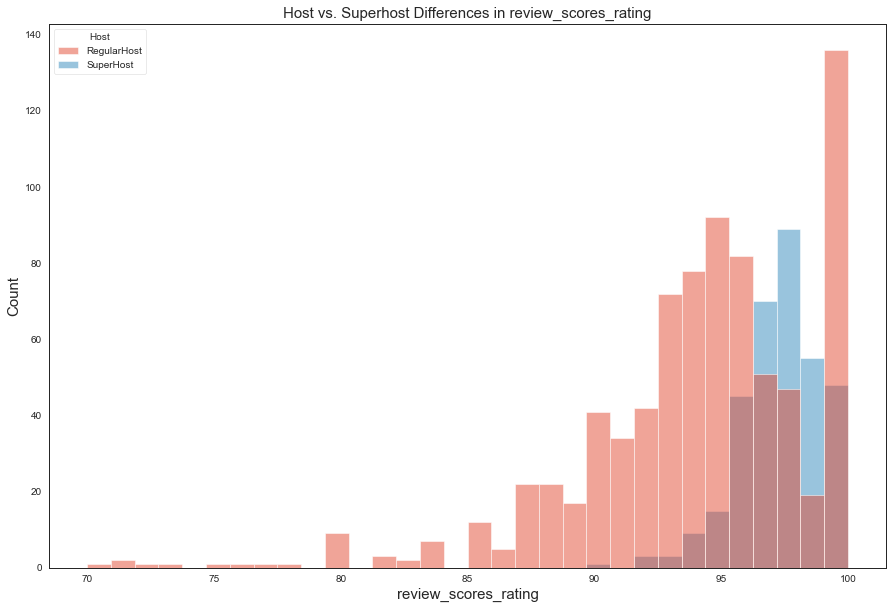

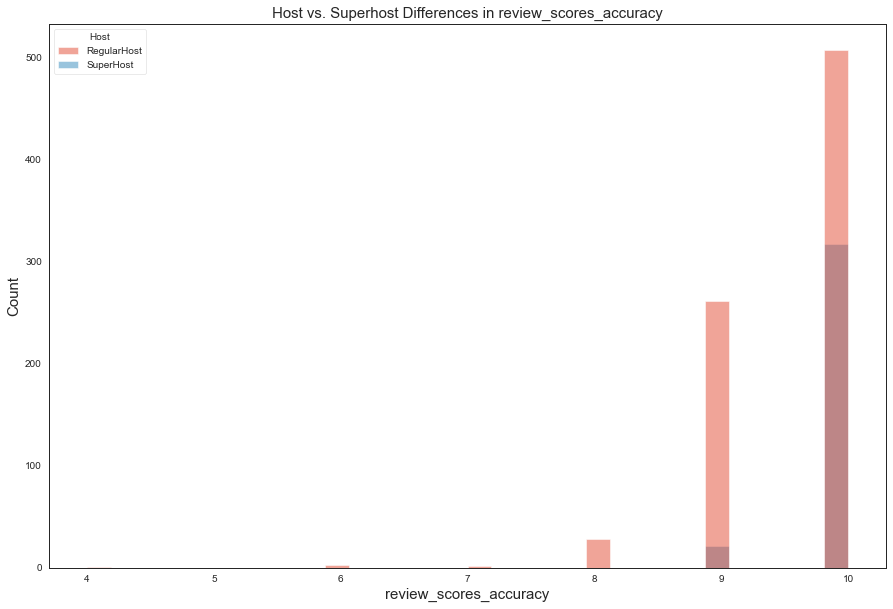

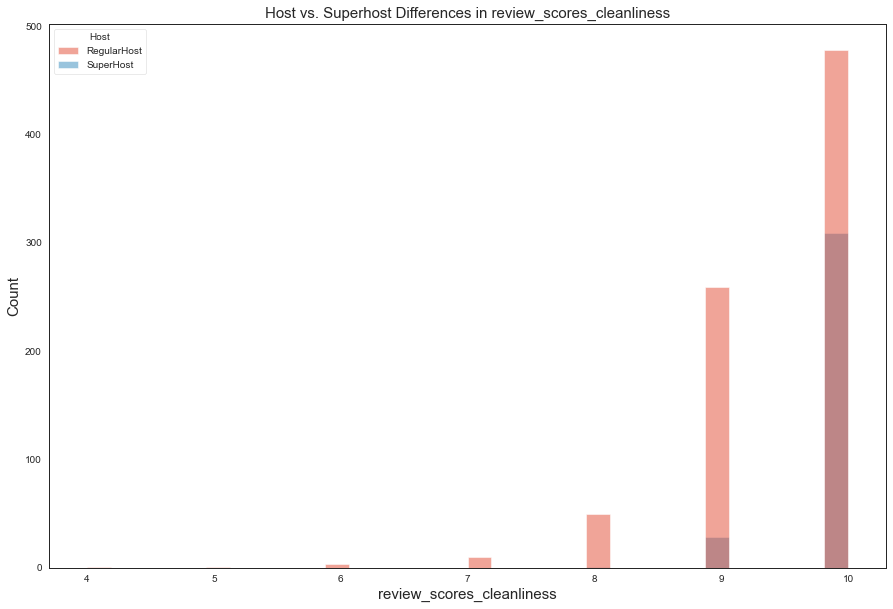

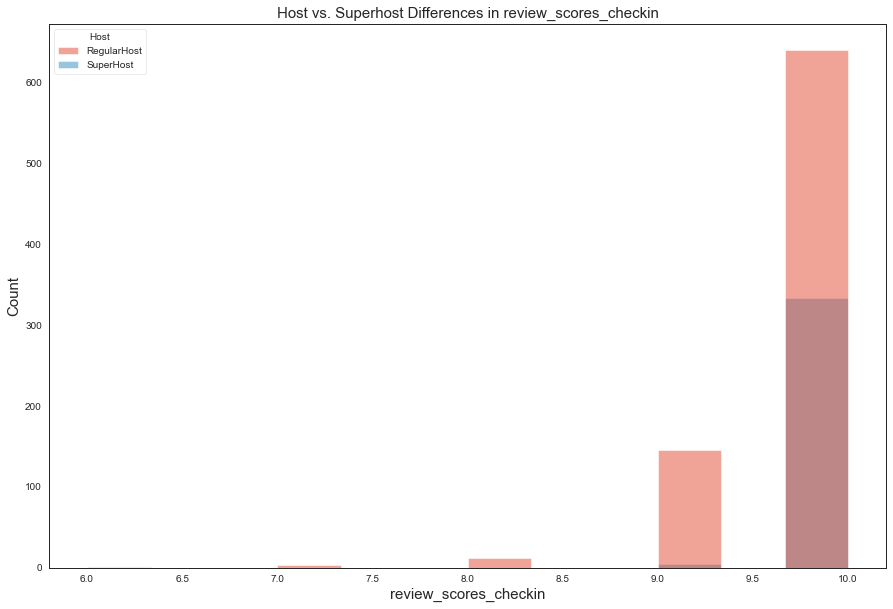

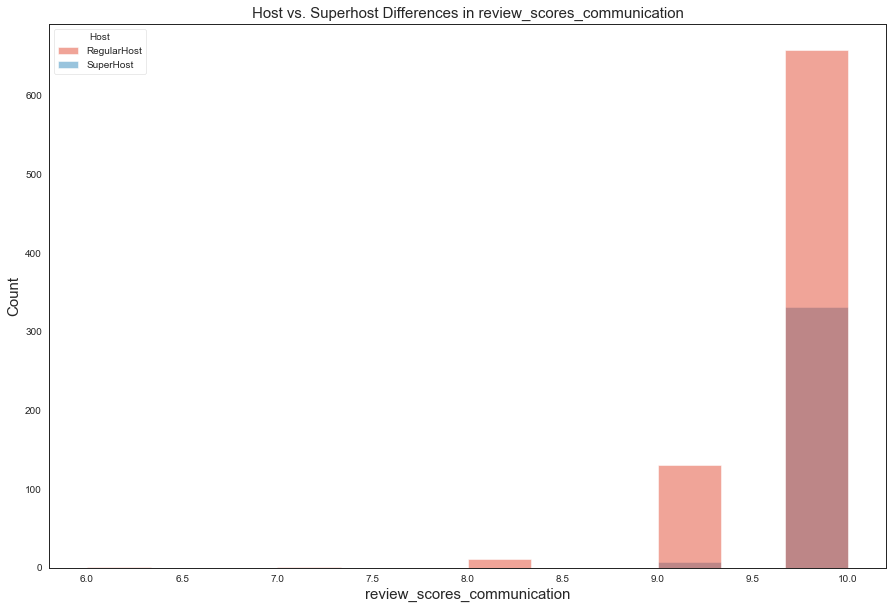

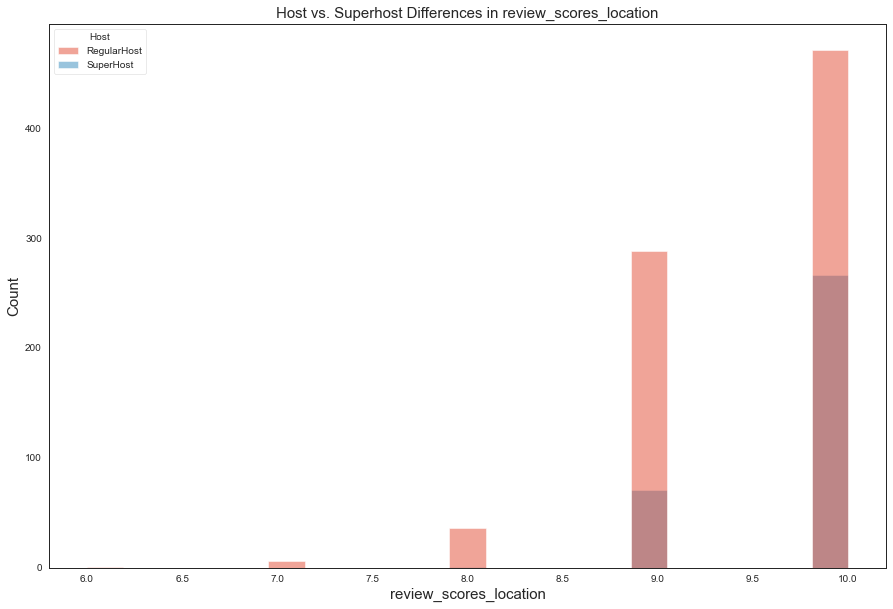

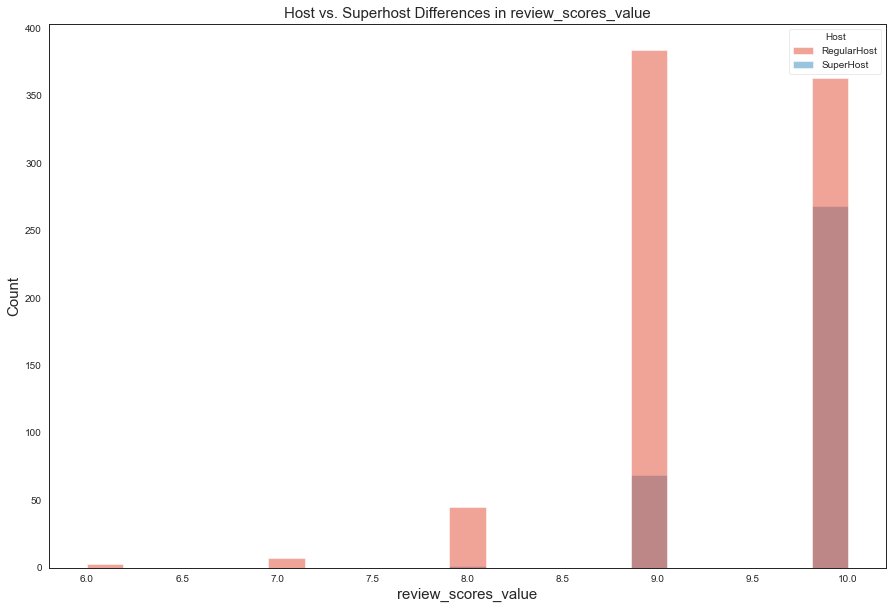

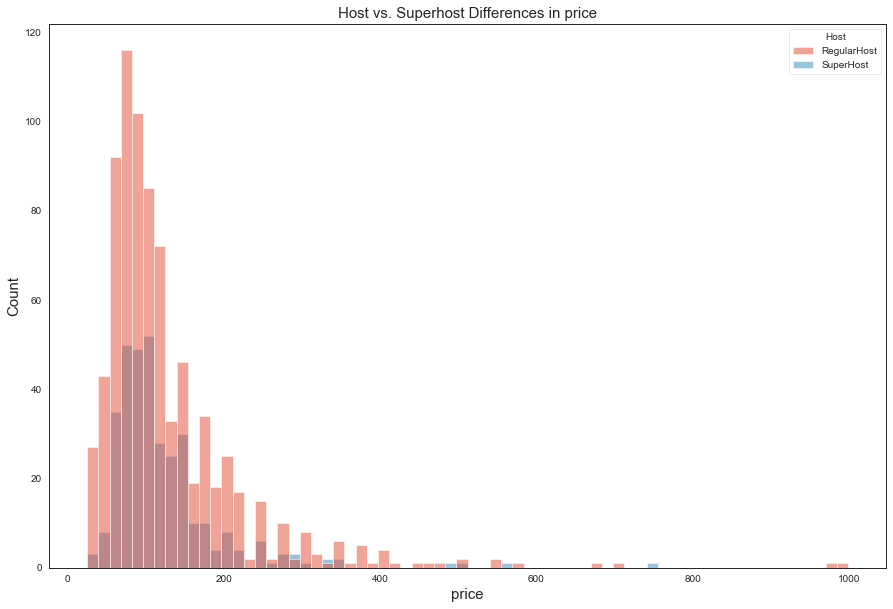

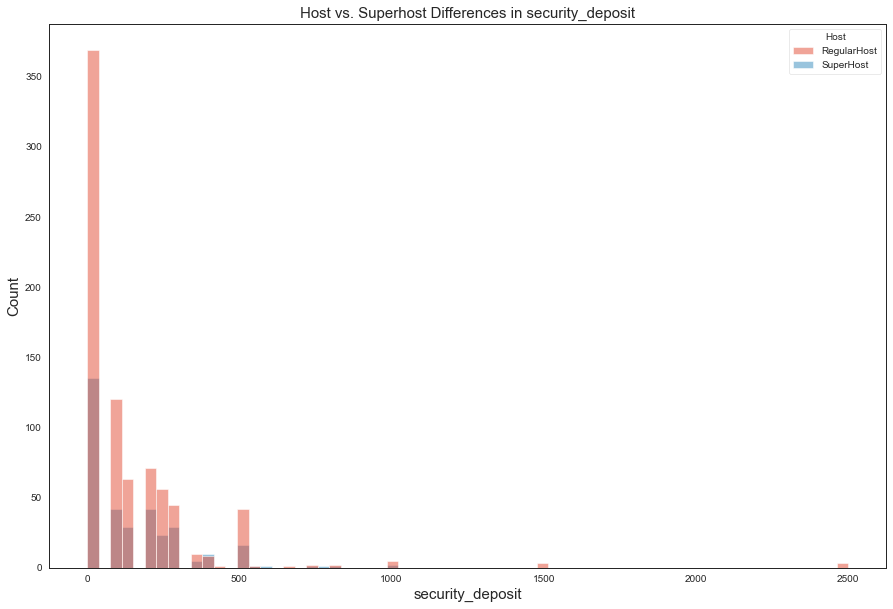

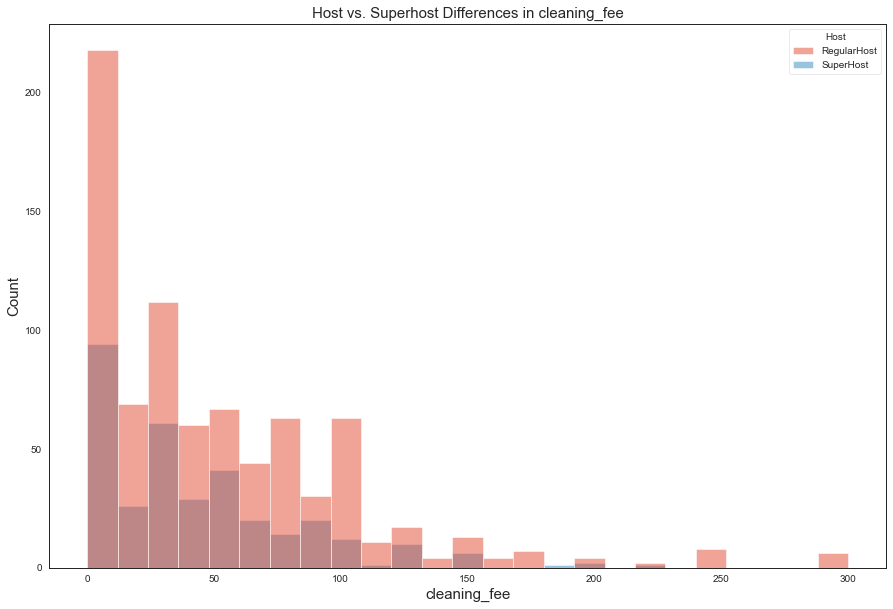

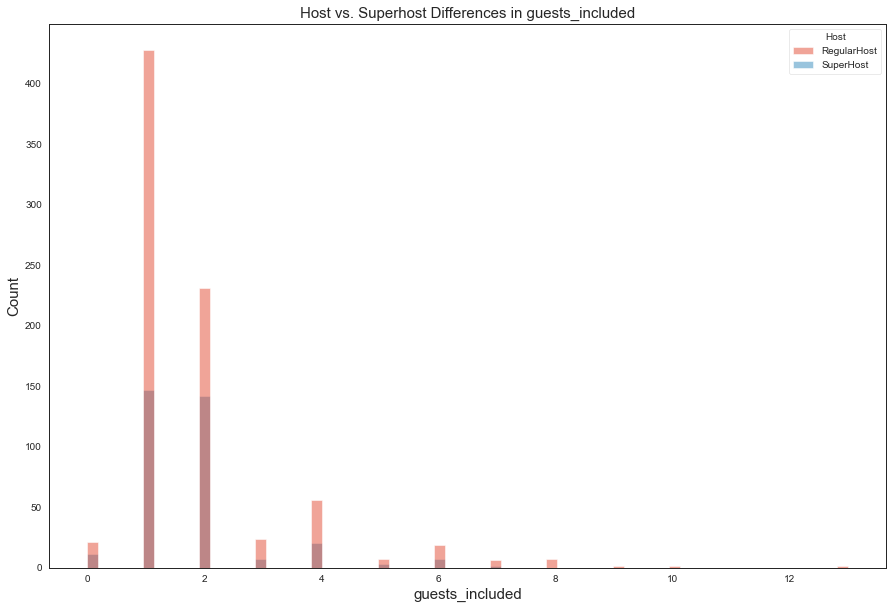

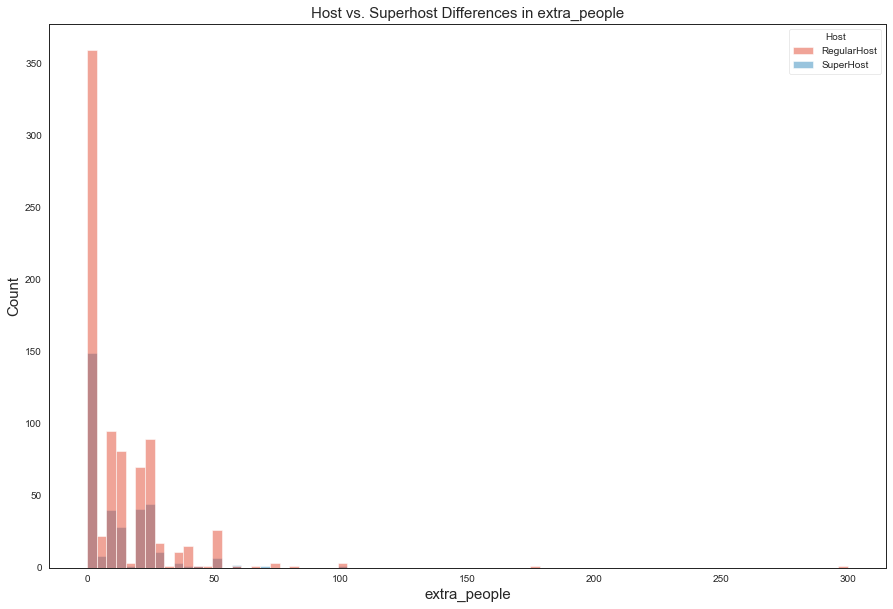

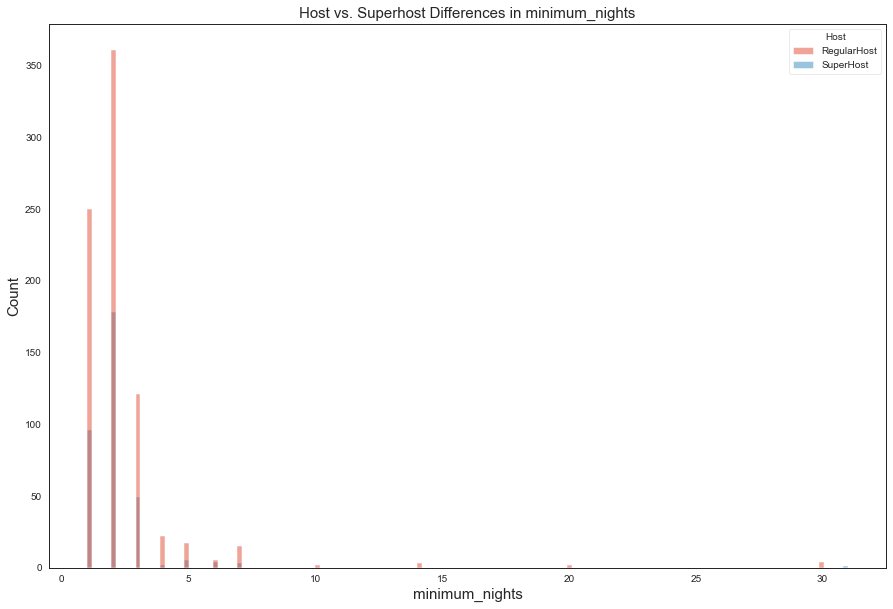

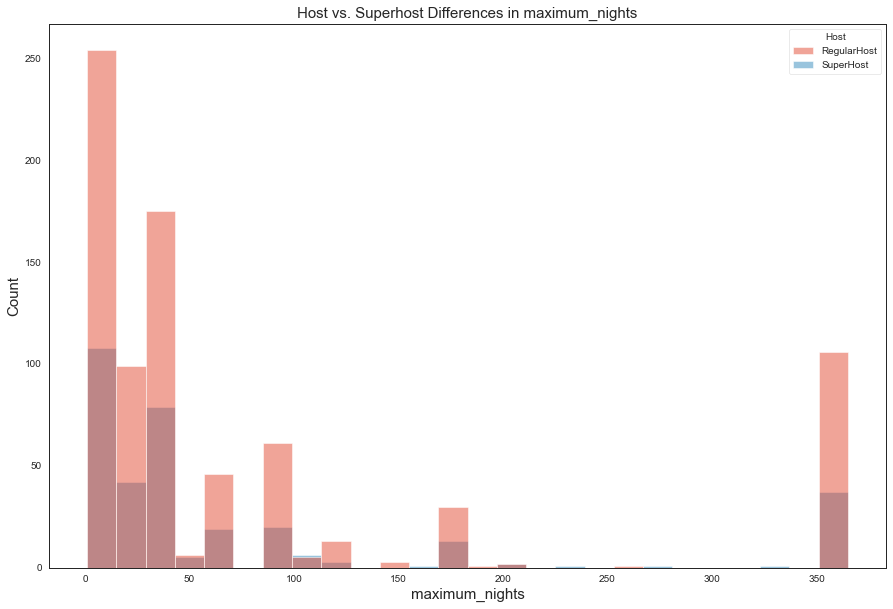

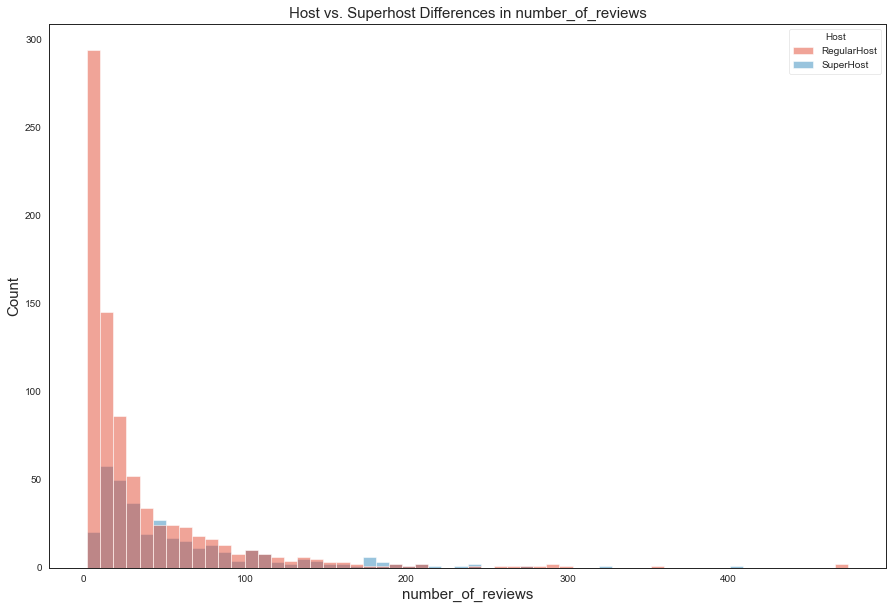

In [206]:
# check for distributions
cols = ['review_scores_rating','review_scores_accuracy', 'review_scores_cleanliness','review_scores_checkin', 
        'review_scores_communication','review_scores_location', 'review_scores_value', 'price',
       'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people','minimum_nights', 
        'maximum_nights', 'number_of_reviews']
for col in cols:
    hist_plot(data, col)

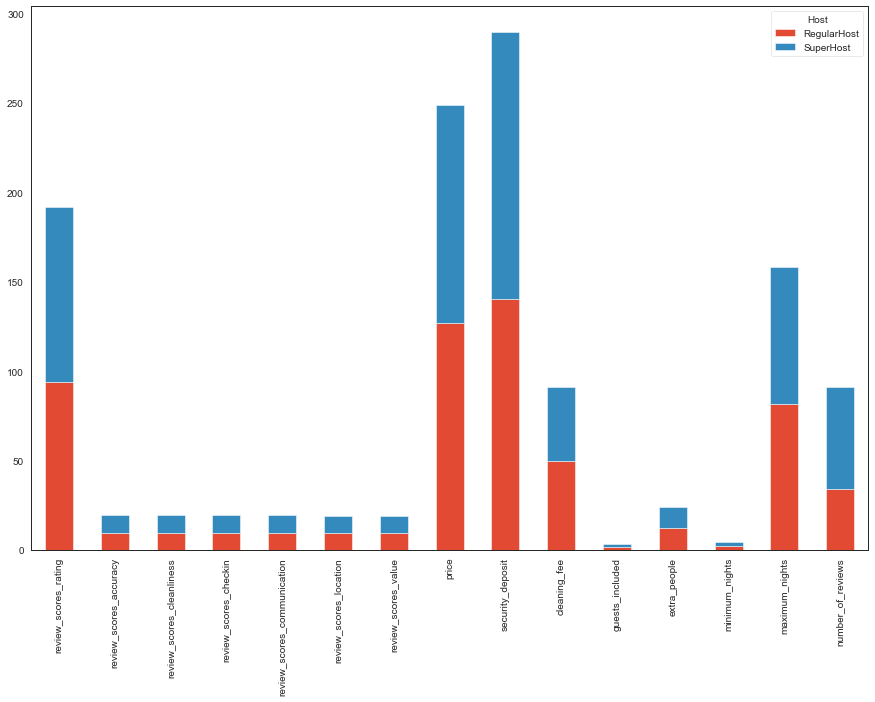

In [227]:
# create a new dataframe to store summary statistics based on host type grouping
#data.drop(columns='id', inplace=True)
host_mean = data.groupby('Host').mean()

host_mean.T.plot(kind='bar', stacked=True,figsize=(15,10))

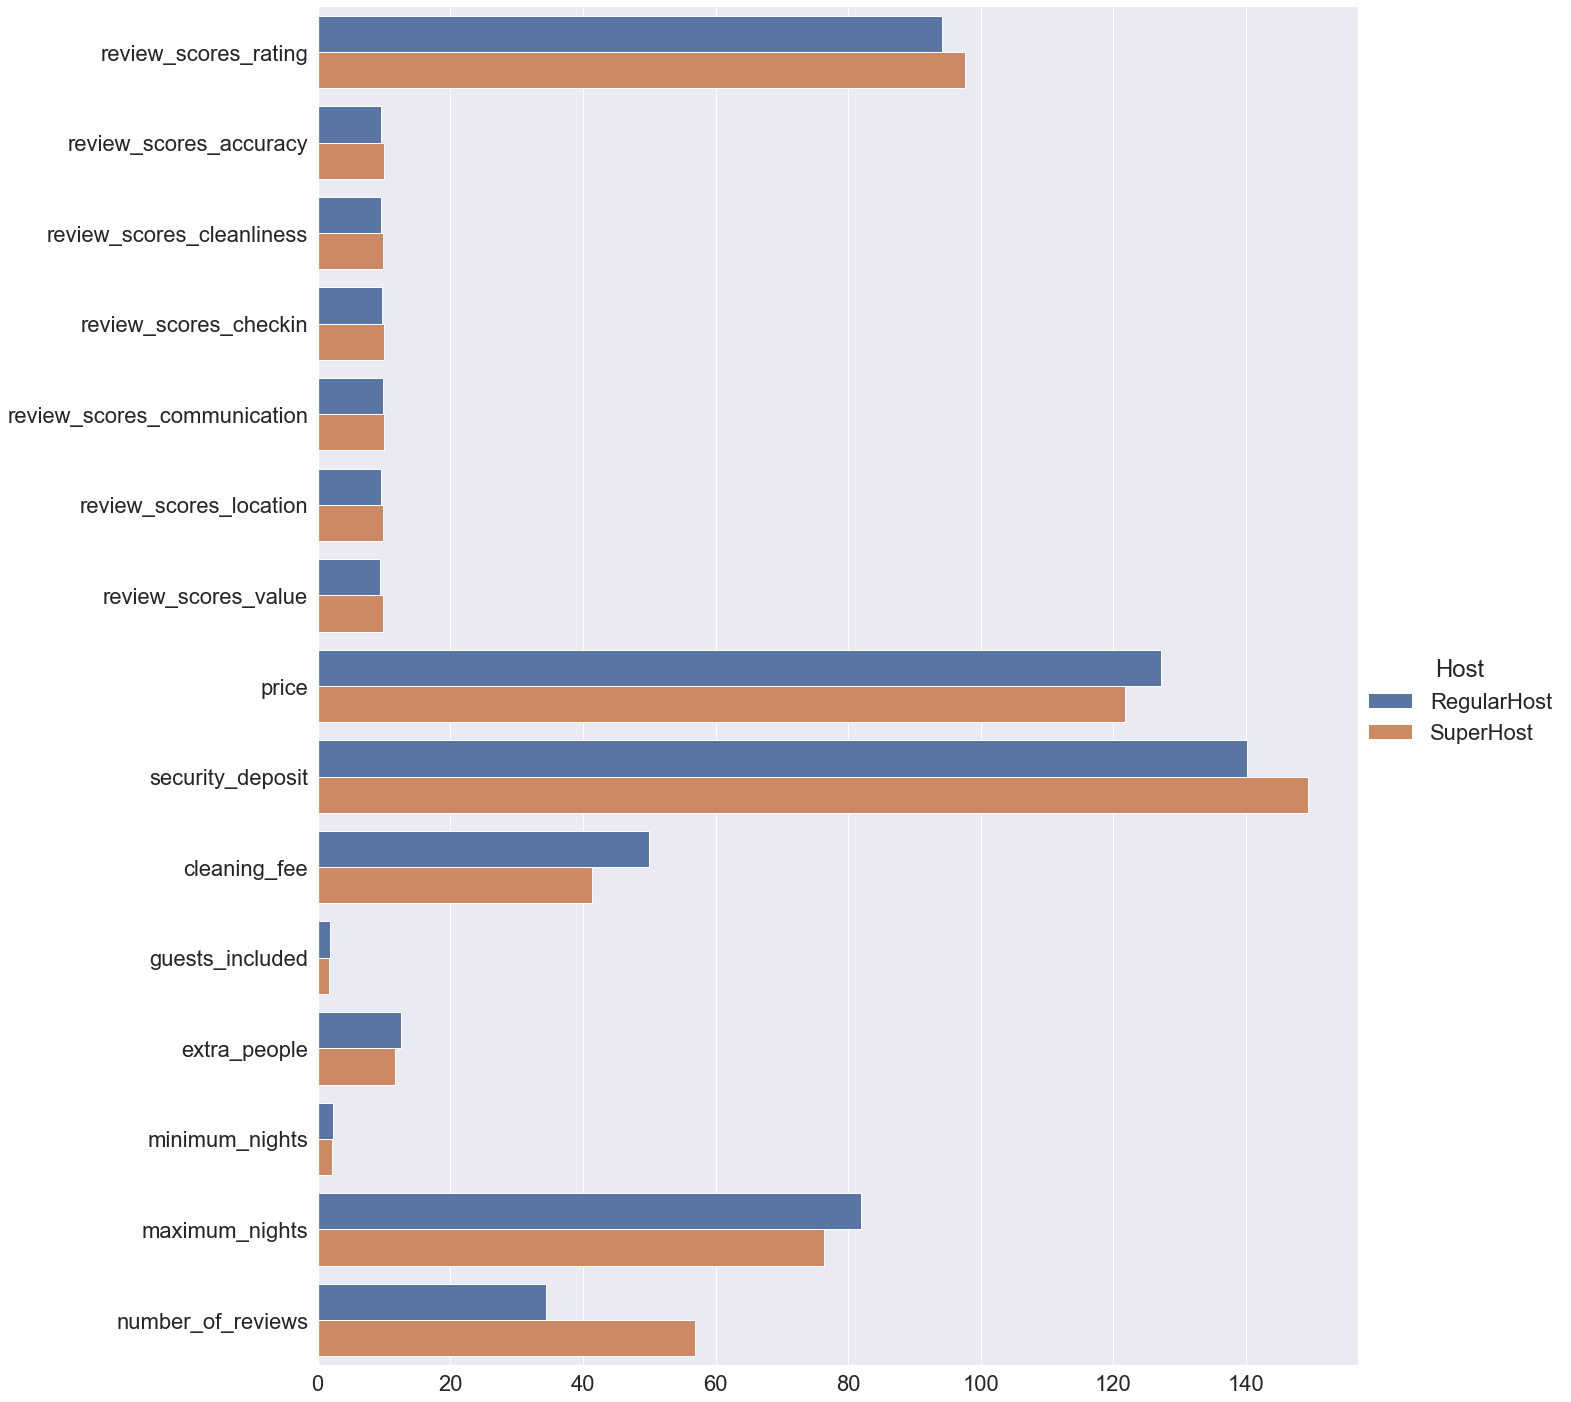

In [272]:
# create a side by side stats plot
#host_mean.reset_index(inplace=True)

host_stats = pd.melt(host_mean, id_vars=['Host'], var_name='type', value_name='stats')

sns.set(font_scale=2, style='darkgrid')
g = sns.catplot(data=host_stats, 
            x = 'stats', 
            y='type', 
            hue = 'Host',
            kind='bar',
            height=20,
            aspect=1)
g.set_xlabels('')
g.set_ylabels('')